# Brain Tumor MRI Dataset Classification
https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset

## Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# !unzip /content/drive/MyDrive/ece285_project/DataSets/UCMerced_LandUse.zip -d /content/drive/MyDrive/ece285_project/DataSets/

In [3]:
import os
import json
import time
import copy
import pickle

import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import cv2

import torch
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
# from torchvision.transforms import ToTensor, Resize
from torchvision.utils import make_grid
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

import torch.backends.cudnn as cudnn
cudnn.benchmark = True

plt.ion()

import sys
sys.path.append('/content/drive/MyDrive/ece285_project/other_projects/SimCLR_v1/')
from models.resnet_simclr import ResNetSimCLR

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Loading Data

In [5]:
root_path = '/content/drive/MyDrive/ece285_project'

In [6]:
# !unzip '/content/drive/MyDrive/ece285_project/DataSets/BrainTumorMRI.zip' -d '/content/drive/MyDrive/ece285_project/DataSets'

In [7]:
label_map = {'glioma':0, 'meningioma':1, 'notumor':2, 'pituitary':3}
label_map_rev = {v:k for k,v in label_map.items()}
label_map

{'glioma': 0, 'meningioma': 1, 'notumor': 2, 'pituitary': 3}

In [8]:
trainval_image_paths = []
trainval_imgs_path = 'DataSets/BrainTumorMRI/Training/'
label_folders = os.listdir(os.path.join(root_path, trainval_imgs_path))

for folder in label_folders:
  imgs = os.listdir(os.path.join(root_path, trainval_imgs_path, folder))
  for img in imgs:
    trainval_image_paths.append(os.path.join(trainval_imgs_path, folder, img))


test_image_paths = []
test_imgs_path = 'DataSets/BrainTumorMRI/Testing/'
label_folders = os.listdir(os.path.join(root_path, test_imgs_path))

for folder in label_folders:
  imgs = os.listdir(os.path.join(root_path, test_imgs_path, folder))
  for img in imgs:
    test_image_paths.append(os.path.join(test_imgs_path, folder, img))

trainval_image_paths = pd.DataFrame(trainval_image_paths, columns=['trainval_img_path'])
test_image_paths = pd.DataFrame(test_image_paths, columns=['test_img_path'])

In [9]:
print(len(trainval_image_paths))
print(len(test_image_paths))

5712
1311


In [10]:
5712*0.75

4284.0

## PyTorch DataLoader

In [11]:
train_transforms = transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224))
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

test_transforms = transforms.Compose([
        # transforms.RandomResizedCrop(224),
        # transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Resize((224, 224))
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  ])

# data_transforms = transforms.Compose([
#             transforms.RandomSizedCrop(224),
#             transforms.RandomHorizontalFlip(),
#             transforms.ToTensor(),
#             transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
#   ])

In [12]:
class ImageDataset(Dataset):
  def __init__(self, image_paths, label_map, transform=None, target_transform=None):
    self.image_paths = image_paths
    self.label_map = label_map
    self.transform = transform
    self.target_transform = target_transform

  def __len__(self):
    return len(self.image_paths)

  def __getitem__(self, idx):
    img_path = self.image_paths.iloc[idx, 0]
    image = Image.open(os.path.join(root_path, img_path)).convert('RGB')
    label = torch.tensor(self.label_map[img_path.split('/')[-2]])

    if self.transform:
            image = self.transform(image)
    if self.target_transform:
        label = self.target_transform(label)
    return image, label

In [13]:
trainval_dataset = ImageDataset(trainval_image_paths, label_map, transform=train_transforms)
test_dataset = ImageDataset(test_image_paths, label_map, transform=train_transforms)

In [14]:
train_dataset, valid_dataset = random_split(trainval_dataset, [4284, 5712-4284], generator=torch.Generator().manual_seed(42))

In [15]:
datasets = {
    'train': train_dataset,
    'valid': valid_dataset,
    'test': test_dataset
}

dataset_sizes = {x: len(datasets[x]) for x in ['train', 'valid', 'test']}

# train_dataset = ImageDataset(train_image_paths, label_map, transform=data_transforms)
# valid_dataset = ImageDataset(valid_image_paths, label_map, transform=data_transforms)
# test_dataset = ImageDataset(test_image_paths, label_map, transform=data_transforms)
dataset_sizes

{'test': 1311, 'train': 4284, 'valid': 1428}

In [16]:
from torchvision.utils import make_grid

2633
pituitary


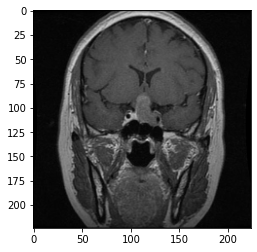

In [17]:
idx = np.random.choice(len(datasets['train']))
print(idx)
plt.imshow(datasets['train'][idx][0].permute(1,2,0))
print(label_map_rev[datasets['train'][idx][1].item()])

In [18]:
# print(torch.sum(datasets['train'][3024][0][0,:,:]))
# print(torch.sum(datasets['train'][3024][0][1,:,:]))
# print(torch.sum(datasets['train'][3024][0][2,:,:]))

In [19]:
# train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
# valid_dataloader = DataLoader(valid_dataset, batch_size=64, shuffle=True)
# test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

## Training and Evaluate Pipeline

In [20]:
from tqdm import tqdm

In [21]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    metrics_dict = {'train_loss': [], 'train_acc': [], 'valid_loss': [], 'valid_acc': []}

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in tqdm(range(num_epochs)):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # print(inputs)
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            
            if phase=='train':
              metrics_dict['train_loss'].append(epoch_loss)
              metrics_dict['train_acc'].append(epoch_acc.item())
            else:
              metrics_dict['valid_loss'].append(epoch_loss)
              metrics_dict['valid_acc'].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, metrics_dict

In [22]:
def visualize_model(model, dataloaders, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['valid']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {label_map_rev[preds[j].item()]}')
                plt.imshow(inputs.cpu().data[j].T)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [23]:
def evaluate_model(model, dataloader):

    running_corrects = 0

    model.eval()
    with torch.no_grad():

      # Iterate over data.
      for inputs, labels in dataloader:
          # print(inputs)
          inputs = inputs.to(device)
          labels = labels.to(device)

          outputs = model(inputs)
          _, preds = torch.max(outputs, 1)

          # statistics
          running_corrects += torch.sum(preds == labels.data)
          # running_totals += len(labels)
    
    epoch_acc = running_corrects.double() / len(dataloader.dataset)

    return epoch_acc.item()

## Model

In [24]:
# import torch
# model = torch.hub.load("chenyaofo/pytorch-cifar-models", "cifar10_resnet20", pretrained=True)

In [25]:
# model = models.resnet50(pretrained=False)

# # Changing the final layer
# model.fc = nn.Linear(model.fc.in_features, 21)

# model = model.to(device)

## Train and Evaluate

In [26]:
# BATCH_SIZE = 64
# EPOCHS = 50
# LR_RATE = 0.01
# MOMENTUM = 0.9

In [27]:
# dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
#                 for x in ['train', 'valid', 'test']}

In [28]:
# criterion = nn.CrossEntropyLoss()

# optimizer = optim.SGD(model.parameters(), lr=LR_RATE, momentum=MOMENTUM)

# # Decay LR by a factor of 0.1 every 7 epochs
# exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.2)

In [29]:
# model = train_model(model, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

In [30]:
# evaluate_model(model, dataloaders['test'])

## Linear and Finetuned Evaluation

## Linear Evaluation - Supervised

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
LR = [0.01] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [ ]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [ ]:
result_le_sv = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/resnet50_cifar10_supervised_e100/resnet.pth'
    model = models.resnet50(pretrained=False)
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
    model.load_state_dict(torch.load(PATH)['net'])
    model = model.module
    model.fc = nn.Linear(model.fc.in_features, 21)
    for name, param in model.named_parameters():
      if 'fc' not in name:
        param.requires_grad = False
    model_le_sv = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_le_sv_best, metrics_dict = train_model(model_le_sv, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_le_sv_best, dataloaders['valid'])
    test_acc = evaluate_model(model_le_sv_best, dataloaders['test'])

    result_le_sv.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
train Loss: 1.2440 Acc: 0.5497


  1%|          | 1/100 [00:48<1:20:08, 48.57s/it]

valid Loss: 0.9383 Acc: 0.7052

Epoch 1/99
train Loss: 0.8776 Acc: 0.6958


  2%|▏         | 2/100 [01:34<1:16:33, 46.87s/it]

valid Loss: 0.7864 Acc: 0.7122

Epoch 2/99
train Loss: 0.8103 Acc: 0.7113


  3%|▎         | 3/100 [02:19<1:14:26, 46.05s/it]

valid Loss: 0.7386 Acc: 0.7640

Epoch 3/99
train Loss: 0.7678 Acc: 0.7264


  4%|▍         | 4/100 [03:04<1:12:51, 45.54s/it]

valid Loss: 0.7124 Acc: 0.7115

Epoch 4/99
train Loss: 0.7361 Acc: 0.7353


  5%|▌         | 5/100 [03:49<1:11:57, 45.44s/it]

valid Loss: 0.6724 Acc: 0.7640

Epoch 5/99
train Loss: 0.7142 Acc: 0.7463


  6%|▌         | 6/100 [04:34<1:11:15, 45.48s/it]

valid Loss: 0.6628 Acc: 0.7668

Epoch 6/99
train Loss: 0.6900 Acc: 0.7505


  7%|▋         | 7/100 [05:19<1:10:02, 45.18s/it]

valid Loss: 0.6411 Acc: 0.7612

Epoch 7/99
train Loss: 0.6858 Acc: 0.7507


  8%|▊         | 8/100 [06:04<1:09:02, 45.03s/it]

valid Loss: 0.6345 Acc: 0.7871

Epoch 8/99
train Loss: 0.6681 Acc: 0.7535


  9%|▉         | 9/100 [06:48<1:08:08, 44.93s/it]

valid Loss: 0.6069 Acc: 0.7913

Epoch 9/99
train Loss: 0.6480 Acc: 0.7687


 10%|█         | 10/100 [07:34<1:07:38, 45.09s/it]

valid Loss: 0.5995 Acc: 0.8004

Epoch 10/99
train Loss: 0.6405 Acc: 0.7731


 11%|█         | 11/100 [08:18<1:06:35, 44.90s/it]

valid Loss: 0.5996 Acc: 0.8039

Epoch 11/99
train Loss: 0.6223 Acc: 0.7836


 12%|█▏        | 12/100 [09:03<1:05:39, 44.76s/it]

valid Loss: 0.5733 Acc: 0.7962

Epoch 12/99
train Loss: 0.6221 Acc: 0.7745


 13%|█▎        | 13/100 [09:47<1:04:44, 44.65s/it]

valid Loss: 0.5721 Acc: 0.7885

Epoch 13/99
train Loss: 0.6110 Acc: 0.7782


 14%|█▍        | 14/100 [10:32<1:04:16, 44.84s/it]

valid Loss: 0.5577 Acc: 0.8137

Epoch 14/99
train Loss: 0.6067 Acc: 0.7899


 15%|█▌        | 15/100 [11:17<1:03:17, 44.68s/it]

valid Loss: 0.5659 Acc: 0.7990

Epoch 15/99
train Loss: 0.5965 Acc: 0.7883


 16%|█▌        | 16/100 [12:01<1:02:29, 44.64s/it]

valid Loss: 0.5551 Acc: 0.7955

Epoch 16/99
train Loss: 0.5897 Acc: 0.7918


 17%|█▋        | 17/100 [12:46<1:01:45, 44.65s/it]

valid Loss: 0.5715 Acc: 0.8130

Epoch 17/99
train Loss: 0.5863 Acc: 0.7885


 18%|█▊        | 18/100 [13:31<1:01:12, 44.79s/it]

valid Loss: 0.5320 Acc: 0.8144

Epoch 18/99
train Loss: 0.5809 Acc: 0.7934


 19%|█▉        | 19/100 [14:16<1:00:20, 44.69s/it]

valid Loss: 0.5340 Acc: 0.8074

Epoch 19/99
train Loss: 0.5708 Acc: 0.8042


 20%|██        | 20/100 [15:00<59:33, 44.67s/it]  

valid Loss: 0.5245 Acc: 0.8179

Epoch 20/99
train Loss: 0.5631 Acc: 0.8025


 21%|██        | 21/100 [15:45<58:52, 44.71s/it]

valid Loss: 0.5391 Acc: 0.8207

Epoch 21/99
train Loss: 0.5610 Acc: 0.8009


 22%|██▏       | 22/100 [16:31<58:27, 44.96s/it]

valid Loss: 0.5368 Acc: 0.8214

Epoch 22/99
train Loss: 0.5591 Acc: 0.8011


 23%|██▎       | 23/100 [17:16<57:53, 45.10s/it]

valid Loss: 0.5069 Acc: 0.8333

Epoch 23/99
train Loss: 0.5598 Acc: 0.8035


 24%|██▍       | 24/100 [18:01<57:08, 45.12s/it]

valid Loss: 0.5126 Acc: 0.8368

Epoch 24/99
train Loss: 0.5554 Acc: 0.8060


 25%|██▌       | 25/100 [18:46<56:26, 45.15s/it]

valid Loss: 0.5050 Acc: 0.8235

Epoch 25/99
train Loss: 0.5409 Acc: 0.8098


 26%|██▌       | 26/100 [19:32<55:59, 45.40s/it]

valid Loss: 0.5029 Acc: 0.8172

Epoch 26/99
train Loss: 0.5459 Acc: 0.8098


 27%|██▋       | 27/100 [20:18<55:12, 45.38s/it]

valid Loss: 0.5041 Acc: 0.8417

Epoch 27/99
train Loss: 0.5446 Acc: 0.8098


 28%|██▊       | 28/100 [21:03<54:22, 45.31s/it]

valid Loss: 0.5215 Acc: 0.8165

Epoch 28/99
train Loss: 0.5346 Acc: 0.8137


 29%|██▉       | 29/100 [21:48<53:36, 45.30s/it]

valid Loss: 0.4914 Acc: 0.8221

Epoch 29/99
train Loss: 0.5291 Acc: 0.8182


 30%|███       | 30/100 [22:34<53:10, 45.58s/it]

valid Loss: 0.4820 Acc: 0.8424

Epoch 30/99
train Loss: 0.5203 Acc: 0.8259


 31%|███       | 31/100 [23:20<52:21, 45.53s/it]

valid Loss: 0.4842 Acc: 0.8263

Epoch 31/99
train Loss: 0.5218 Acc: 0.8189


 32%|███▏      | 32/100 [24:05<51:28, 45.42s/it]

valid Loss: 0.4869 Acc: 0.8480

Epoch 32/99
train Loss: 0.5308 Acc: 0.8177


 33%|███▎      | 33/100 [24:50<50:37, 45.33s/it]

valid Loss: 0.5027 Acc: 0.8200

Epoch 33/99
train Loss: 0.5237 Acc: 0.8214


 34%|███▍      | 34/100 [25:36<49:58, 45.42s/it]

valid Loss: 0.4955 Acc: 0.8487

Epoch 34/99
train Loss: 0.5128 Acc: 0.8263


 35%|███▌      | 35/100 [26:21<49:10, 45.39s/it]

valid Loss: 0.4699 Acc: 0.8354

Epoch 35/99
train Loss: 0.5053 Acc: 0.8303


 36%|███▌      | 36/100 [27:06<48:19, 45.30s/it]

valid Loss: 0.4749 Acc: 0.8375

Epoch 36/99
train Loss: 0.5176 Acc: 0.8231


 37%|███▋      | 37/100 [27:51<47:35, 45.32s/it]

valid Loss: 0.4744 Acc: 0.8403

Epoch 37/99
train Loss: 0.5037 Acc: 0.8324


 38%|███▊      | 38/100 [28:36<46:44, 45.23s/it]

valid Loss: 0.4727 Acc: 0.8466

Epoch 38/99
train Loss: 0.5041 Acc: 0.8294


 39%|███▉      | 39/100 [29:22<46:07, 45.38s/it]

valid Loss: 0.4661 Acc: 0.8494

Epoch 39/99
train Loss: 0.5049 Acc: 0.8305


 40%|████      | 40/100 [30:07<45:15, 45.26s/it]

valid Loss: 0.4619 Acc: 0.8438

Epoch 40/99
train Loss: 0.5056 Acc: 0.8326


 41%|████      | 41/100 [30:52<44:26, 45.19s/it]

valid Loss: 0.4613 Acc: 0.8333

Epoch 41/99
train Loss: 0.5044 Acc: 0.8270


 42%|████▏     | 42/100 [31:37<43:39, 45.16s/it]

valid Loss: 0.4580 Acc: 0.8403

Epoch 42/99
train Loss: 0.4926 Acc: 0.8331


 43%|████▎     | 43/100 [32:24<43:26, 45.73s/it]

valid Loss: 0.4641 Acc: 0.8564

Epoch 43/99
train Loss: 0.4932 Acc: 0.8277


 44%|████▍     | 44/100 [33:12<43:06, 46.19s/it]

valid Loss: 0.4673 Acc: 0.8536

Epoch 44/99
train Loss: 0.5061 Acc: 0.8287


 45%|████▌     | 45/100 [33:57<42:12, 46.05s/it]

valid Loss: 0.4633 Acc: 0.8417

Epoch 45/99
train Loss: 0.4994 Acc: 0.8294


 46%|████▌     | 46/100 [34:42<41:10, 45.75s/it]

valid Loss: 0.4530 Acc: 0.8368

Epoch 46/99
train Loss: 0.4938 Acc: 0.8333


 47%|████▋     | 47/100 [35:29<40:39, 46.04s/it]

valid Loss: 0.4601 Acc: 0.8319

Epoch 47/99
train Loss: 0.4872 Acc: 0.8382


 48%|████▊     | 48/100 [36:14<39:40, 45.78s/it]

valid Loss: 0.4522 Acc: 0.8466

Epoch 48/99
train Loss: 0.4939 Acc: 0.8317


 49%|████▉     | 49/100 [36:59<38:46, 45.61s/it]

valid Loss: 0.4474 Acc: 0.8431

Epoch 49/99
train Loss: 0.4847 Acc: 0.8331


 50%|█████     | 50/100 [37:45<37:54, 45.50s/it]

valid Loss: 0.4477 Acc: 0.8536

Epoch 50/99
train Loss: 0.4819 Acc: 0.8357


 51%|█████     | 51/100 [38:31<37:19, 45.69s/it]

valid Loss: 0.4440 Acc: 0.8571

Epoch 51/99
train Loss: 0.4837 Acc: 0.8380


 52%|█████▏    | 52/100 [39:16<36:23, 45.49s/it]

valid Loss: 0.4433 Acc: 0.8480

Epoch 52/99
train Loss: 0.4843 Acc: 0.8317


 53%|█████▎    | 53/100 [40:01<35:33, 45.40s/it]

valid Loss: 0.4405 Acc: 0.8564

Epoch 53/99
train Loss: 0.4838 Acc: 0.8394


 54%|█████▍    | 54/100 [40:46<34:42, 45.27s/it]

valid Loss: 0.4458 Acc: 0.8410

Epoch 54/99
train Loss: 0.4788 Acc: 0.8389


 55%|█████▌    | 55/100 [41:32<34:04, 45.44s/it]

valid Loss: 0.4334 Acc: 0.8606

Epoch 55/99
train Loss: 0.4790 Acc: 0.8347


 56%|█████▌    | 56/100 [42:17<33:14, 45.34s/it]

valid Loss: 0.4383 Acc: 0.8592

Epoch 56/99
train Loss: 0.4737 Acc: 0.8403


 57%|█████▋    | 57/100 [43:02<32:28, 45.31s/it]

valid Loss: 0.4351 Acc: 0.8543

Epoch 57/99
train Loss: 0.4705 Acc: 0.8413


 58%|█████▊    | 58/100 [43:47<31:41, 45.28s/it]

valid Loss: 0.4384 Acc: 0.8487

Epoch 58/99
train Loss: 0.4783 Acc: 0.8410


 59%|█████▉    | 59/100 [44:33<31:02, 45.44s/it]

valid Loss: 0.4328 Acc: 0.8669

Epoch 59/99
train Loss: 0.4709 Acc: 0.8429


 60%|██████    | 60/100 [45:18<30:14, 45.37s/it]

valid Loss: 0.4383 Acc: 0.8571

Epoch 60/99
train Loss: 0.4747 Acc: 0.8387


 61%|██████    | 61/100 [46:04<29:26, 45.28s/it]

valid Loss: 0.4341 Acc: 0.8515

Epoch 61/99
train Loss: 0.4666 Acc: 0.8480


 62%|██████▏   | 62/100 [46:49<28:38, 45.22s/it]

valid Loss: 0.4264 Acc: 0.8606

Epoch 62/99
train Loss: 0.4674 Acc: 0.8452


 63%|██████▎   | 63/100 [47:34<27:57, 45.34s/it]

valid Loss: 0.4267 Acc: 0.8564

Epoch 63/99
train Loss: 0.4632 Acc: 0.8429


 64%|██████▍   | 64/100 [48:20<27:11, 45.33s/it]

valid Loss: 0.4314 Acc: 0.8571

Epoch 64/99
train Loss: 0.4616 Acc: 0.8494


 65%|██████▌   | 65/100 [49:05<26:24, 45.28s/it]

valid Loss: 0.4413 Acc: 0.8606

Epoch 65/99
train Loss: 0.4638 Acc: 0.8499


 66%|██████▌   | 66/100 [49:50<25:39, 45.27s/it]

valid Loss: 0.4288 Acc: 0.8564

Epoch 66/99
train Loss: 0.4658 Acc: 0.8420


 67%|██████▋   | 67/100 [50:36<25:00, 45.46s/it]

valid Loss: 0.4306 Acc: 0.8592

Epoch 67/99
train Loss: 0.4633 Acc: 0.8455


 68%|██████▊   | 68/100 [51:21<24:10, 45.34s/it]

valid Loss: 0.4217 Acc: 0.8606

Epoch 68/99
train Loss: 0.4539 Acc: 0.8550


 69%|██████▉   | 69/100 [52:06<23:23, 45.27s/it]

valid Loss: 0.4257 Acc: 0.8634

Epoch 69/99
train Loss: 0.4594 Acc: 0.8464


 70%|███████   | 70/100 [52:51<22:35, 45.18s/it]

valid Loss: 0.4270 Acc: 0.8564

Epoch 70/99
train Loss: 0.4554 Acc: 0.8483


 71%|███████   | 71/100 [53:37<21:57, 45.43s/it]

valid Loss: 0.4207 Acc: 0.8578

Epoch 71/99
train Loss: 0.4569 Acc: 0.8487


 72%|███████▏  | 72/100 [54:22<21:08, 45.32s/it]

valid Loss: 0.4206 Acc: 0.8634

Epoch 72/99
train Loss: 0.4605 Acc: 0.8476


 73%|███████▎  | 73/100 [55:07<20:20, 45.21s/it]

valid Loss: 0.4214 Acc: 0.8578

Epoch 73/99
train Loss: 0.4535 Acc: 0.8483


 74%|███████▍  | 74/100 [55:52<19:34, 45.18s/it]

valid Loss: 0.4192 Acc: 0.8606

Epoch 74/99
train Loss: 0.4556 Acc: 0.8464


 75%|███████▌  | 75/100 [56:38<18:51, 45.28s/it]

valid Loss: 0.4216 Acc: 0.8599

Epoch 75/99
train Loss: 0.4596 Acc: 0.8408


 76%|███████▌  | 76/100 [57:22<18:00, 45.04s/it]

valid Loss: 0.4178 Acc: 0.8571

Epoch 76/99
train Loss: 0.4490 Acc: 0.8539


 77%|███████▋  | 77/100 [58:06<17:09, 44.74s/it]

valid Loss: 0.4174 Acc: 0.8599

Epoch 77/99
train Loss: 0.4511 Acc: 0.8518


 78%|███████▊  | 78/100 [58:51<16:23, 44.72s/it]

valid Loss: 0.4151 Acc: 0.8578

Epoch 78/99
train Loss: 0.4515 Acc: 0.8511


 79%|███████▉  | 79/100 [59:35<15:35, 44.55s/it]

valid Loss: 0.4146 Acc: 0.8683

Epoch 79/99
train Loss: 0.4530 Acc: 0.8525


 80%|████████  | 80/100 [1:00:20<14:53, 44.65s/it]

valid Loss: 0.4143 Acc: 0.8641

Epoch 80/99
train Loss: 0.4504 Acc: 0.8522


 81%|████████  | 81/100 [1:01:04<14:06, 44.55s/it]

valid Loss: 0.4163 Acc: 0.8711

Epoch 81/99
train Loss: 0.4467 Acc: 0.8494


 82%|████████▏ | 82/100 [1:01:48<13:19, 44.44s/it]

valid Loss: 0.4130 Acc: 0.8754

Epoch 82/99
train Loss: 0.4460 Acc: 0.8536


 83%|████████▎ | 83/100 [1:02:33<12:34, 44.39s/it]

valid Loss: 0.4101 Acc: 0.8704

Epoch 83/99
train Loss: 0.4503 Acc: 0.8506


 84%|████████▍ | 84/100 [1:03:17<11:52, 44.54s/it]

valid Loss: 0.4094 Acc: 0.8627

Epoch 84/99
train Loss: 0.4414 Acc: 0.8527


 85%|████████▌ | 85/100 [1:04:02<11:08, 44.58s/it]

valid Loss: 0.4110 Acc: 0.8676

Epoch 85/99
train Loss: 0.4508 Acc: 0.8497


 86%|████████▌ | 86/100 [1:04:46<10:22, 44.44s/it]

valid Loss: 0.4126 Acc: 0.8634

Epoch 86/99
train Loss: 0.4460 Acc: 0.8513


 87%|████████▋ | 87/100 [1:05:31<09:36, 44.38s/it]

valid Loss: 0.4129 Acc: 0.8655

Epoch 87/99
train Loss: 0.4529 Acc: 0.8527


 88%|████████▊ | 88/100 [1:06:15<08:54, 44.54s/it]

valid Loss: 0.4165 Acc: 0.8704

Epoch 88/99
train Loss: 0.4403 Acc: 0.8578


 89%|████████▉ | 89/100 [1:07:00<08:08, 44.43s/it]

valid Loss: 0.4211 Acc: 0.8655

Epoch 89/99
train Loss: 0.4425 Acc: 0.8550


 90%|█████████ | 90/100 [1:07:44<07:23, 44.35s/it]

valid Loss: 0.4062 Acc: 0.8662

Epoch 90/99
train Loss: 0.4434 Acc: 0.8564


 91%|█████████ | 91/100 [1:08:28<06:38, 44.28s/it]

valid Loss: 0.4074 Acc: 0.8768

Epoch 91/99
train Loss: 0.4360 Acc: 0.8557


 92%|█████████▏| 92/100 [1:09:13<05:56, 44.54s/it]

valid Loss: 0.4035 Acc: 0.8711

Epoch 92/99
train Loss: 0.4373 Acc: 0.8550


 93%|█████████▎| 93/100 [1:09:57<05:10, 44.41s/it]

valid Loss: 0.4052 Acc: 0.8704

Epoch 93/99
train Loss: 0.4390 Acc: 0.8595


 94%|█████████▍| 94/100 [1:10:41<04:26, 44.35s/it]

valid Loss: 0.4119 Acc: 0.8578

Epoch 94/99
train Loss: 0.4393 Acc: 0.8548


 95%|█████████▌| 95/100 [1:11:26<03:41, 44.34s/it]

valid Loss: 0.4005 Acc: 0.8683

Epoch 95/99
train Loss: 0.4388 Acc: 0.8550


 96%|█████████▌| 96/100 [1:12:10<02:57, 44.31s/it]

valid Loss: 0.4047 Acc: 0.8683

Epoch 96/99
train Loss: 0.4416 Acc: 0.8548


 97%|█████████▋| 97/100 [1:12:55<02:13, 44.47s/it]

valid Loss: 0.4049 Acc: 0.8676

Epoch 97/99
train Loss: 0.4402 Acc: 0.8541


 98%|█████████▊| 98/100 [1:13:39<01:28, 44.38s/it]

valid Loss: 0.4067 Acc: 0.8627

Epoch 98/99
train Loss: 0.4386 Acc: 0.8560


 99%|█████████▉| 99/100 [1:14:23<00:44, 44.39s/it]

valid Loss: 0.4008 Acc: 0.8683

Epoch 99/99
train Loss: 0.4384 Acc: 0.8527


100%|██████████| 100/100 [1:15:08<00:00, 45.08s/it]

valid Loss: 0.4053 Acc: 0.8592

Training complete in 75m 8s
Best val Acc: 0.876751


In [ ]:
result_df = pd.DataFrame(result_le_sv, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.01,0.0001,0.876751,0.810831,"{'train_loss': [1.2439753206170239, 0.87758752..."


In [ ]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/braintumor_result_le_sv.pkl')
# result_df.to_csv('/content/drive/MyDrive/ece285_project/results/satlanduse_result_le_sv.csv', index=False)

## Linear Evaluation - SSL

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
LR = [0.01] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [ ]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [ ]:
result_le_ssl = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/simclr_cifar_10_resnet50_100e/checkpoint_0100.pth.tar'
    model = ResNetSimCLR('resnet50', 128)
    model.load_state_dict(torch.load(PATH)['state_dict'])
    model = model.backbone
    model.fc = nn.Linear(model.fc[2].in_features, 21)
    for name, param in model.named_parameters():
      if 'fc' not in name:
        param.requires_grad = False
    model_le_ssl = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_le_ssl_best, metrics_dict = train_model(model_le_ssl, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_le_ssl_best, dataloaders['valid'])
    test_acc = evaluate_model(model_le_ssl_best, dataloaders['test'])

    result_le_ssl.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
train Loss: 1.0433 Acc: 0.6169


  1%|          | 1/100 [24:29<40:24:29, 1469.38s/it]

valid Loss: 0.7557 Acc: 0.7178

Epoch 1/99
train Loss: 0.6766 Acc: 0.7619


  2%|▏         | 2/100 [25:14<17:11:39, 631.62s/it] 

valid Loss: 0.6465 Acc: 0.7500

Epoch 2/99
train Loss: 0.6189 Acc: 0.7836


  3%|▎         | 3/100 [26:00<9:48:36, 364.09s/it] 

valid Loss: 0.5902 Acc: 0.7892

Epoch 3/99
train Loss: 0.5595 Acc: 0.8039


  4%|▍         | 4/100 [26:45<6:21:01, 238.14s/it]

valid Loss: 0.5727 Acc: 0.7787

Epoch 4/99
train Loss: 0.5346 Acc: 0.8070


  5%|▌         | 5/100 [27:31<4:27:19, 168.84s/it]

valid Loss: 0.5368 Acc: 0.8158

Epoch 5/99
train Loss: 0.5078 Acc: 0.8228


  6%|▌         | 6/100 [28:16<3:18:41, 126.83s/it]

valid Loss: 0.5305 Acc: 0.7962

Epoch 6/99
train Loss: 0.4878 Acc: 0.8347


  7%|▋         | 7/100 [29:01<2:35:12, 100.13s/it]

valid Loss: 0.5080 Acc: 0.8165

Epoch 7/99
train Loss: 0.4885 Acc: 0.8245


  8%|▊         | 8/100 [29:47<2:06:45, 82.66s/it] 

valid Loss: 0.4697 Acc: 0.8347

Epoch 8/99
train Loss: 0.4816 Acc: 0.8242


  9%|▉         | 9/100 [30:32<1:47:42, 71.01s/it]

valid Loss: 0.4919 Acc: 0.8221

Epoch 9/99
train Loss: 0.4569 Acc: 0.8436


 10%|█         | 10/100 [31:18<1:35:05, 63.39s/it]

valid Loss: 0.4682 Acc: 0.8277

Epoch 10/99
train Loss: 0.4361 Acc: 0.8494


 11%|█         | 11/100 [32:04<1:25:53, 57.91s/it]

valid Loss: 0.4622 Acc: 0.8361

Epoch 11/99
train Loss: 0.4290 Acc: 0.8548


 12%|█▏        | 12/100 [32:49<1:19:13, 54.02s/it]

valid Loss: 0.4670 Acc: 0.8235

Epoch 12/99
train Loss: 0.4337 Acc: 0.8443


 13%|█▎        | 13/100 [33:34<1:14:27, 51.36s/it]

valid Loss: 0.4379 Acc: 0.8494

Epoch 13/99
train Loss: 0.4362 Acc: 0.8420


 14%|█▍        | 14/100 [34:19<1:10:57, 49.50s/it]

valid Loss: 0.4303 Acc: 0.8452

Epoch 14/99
train Loss: 0.4178 Acc: 0.8585


 15%|█▌        | 15/100 [35:04<1:08:11, 48.14s/it]

valid Loss: 0.4267 Acc: 0.8473

Epoch 15/99
train Loss: 0.4122 Acc: 0.8480


 16%|█▌        | 16/100 [35:50<1:06:34, 47.55s/it]

valid Loss: 0.4325 Acc: 0.8501

Epoch 16/99
train Loss: 0.4064 Acc: 0.8634


 17%|█▋        | 17/100 [36:36<1:04:48, 46.85s/it]

valid Loss: 0.4215 Acc: 0.8529

Epoch 17/99
train Loss: 0.3960 Acc: 0.8592


 18%|█▊        | 18/100 [37:21<1:03:23, 46.38s/it]

valid Loss: 0.4161 Acc: 0.8522

Epoch 18/99
train Loss: 0.3964 Acc: 0.8648


 19%|█▉        | 19/100 [38:06<1:02:15, 46.11s/it]

valid Loss: 0.4292 Acc: 0.8592

Epoch 19/99
train Loss: 0.4056 Acc: 0.8548


 20%|██        | 20/100 [38:51<1:01:02, 45.78s/it]

valid Loss: 0.4072 Acc: 0.8599

Epoch 20/99
train Loss: 0.3840 Acc: 0.8667


 21%|██        | 21/100 [39:37<1:00:00, 45.57s/it]

valid Loss: 0.4096 Acc: 0.8585

Epoch 21/99
train Loss: 0.3905 Acc: 0.8669


 22%|██▏       | 22/100 [40:22<59:21, 45.67s/it]  

valid Loss: 0.4229 Acc: 0.8543

Epoch 22/99
train Loss: 0.3768 Acc: 0.8693


 23%|██▎       | 23/100 [41:08<58:25, 45.53s/it]

valid Loss: 0.4009 Acc: 0.8641

Epoch 23/99
train Loss: 0.3751 Acc: 0.8676


 24%|██▍       | 24/100 [41:53<57:42, 45.56s/it]

valid Loss: 0.4199 Acc: 0.8522

Epoch 24/99
train Loss: 0.3878 Acc: 0.8632


 25%|██▌       | 25/100 [42:38<56:44, 45.39s/it]

valid Loss: 0.3905 Acc: 0.8634

Epoch 25/99
train Loss: 0.3755 Acc: 0.8718


 26%|██▌       | 26/100 [43:23<55:52, 45.30s/it]

valid Loss: 0.4122 Acc: 0.8627

Epoch 26/99
train Loss: 0.3719 Acc: 0.8709


 27%|██▋       | 27/100 [44:09<55:08, 45.32s/it]

valid Loss: 0.4042 Acc: 0.8606

Epoch 27/99
train Loss: 0.3785 Acc: 0.8658


 28%|██▊       | 28/100 [44:55<54:34, 45.47s/it]

valid Loss: 0.4367 Acc: 0.8445

Epoch 28/99
train Loss: 0.3879 Acc: 0.8616


 29%|██▉       | 29/100 [45:40<53:42, 45.39s/it]

valid Loss: 0.3897 Acc: 0.8641

Epoch 29/99
train Loss: 0.3663 Acc: 0.8744


 30%|███       | 30/100 [46:25<52:57, 45.40s/it]

valid Loss: 0.4196 Acc: 0.8340

Epoch 30/99
train Loss: 0.3698 Acc: 0.8725


 31%|███       | 31/100 [47:10<52:08, 45.34s/it]

valid Loss: 0.3864 Acc: 0.8676

Epoch 31/99
train Loss: 0.3624 Acc: 0.8775


 32%|███▏      | 32/100 [47:56<51:21, 45.32s/it]

valid Loss: 0.3801 Acc: 0.8768

Epoch 32/99
train Loss: 0.3576 Acc: 0.8754


 33%|███▎      | 33/100 [48:41<50:32, 45.25s/it]

valid Loss: 0.3904 Acc: 0.8683

Epoch 33/99
train Loss: 0.3568 Acc: 0.8725


 34%|███▍      | 34/100 [49:27<49:58, 45.43s/it]

valid Loss: 0.3963 Acc: 0.8550

Epoch 34/99
train Loss: 0.3496 Acc: 0.8819


 35%|███▌      | 35/100 [50:12<49:12, 45.42s/it]

valid Loss: 0.3771 Acc: 0.8711

Epoch 35/99
train Loss: 0.3568 Acc: 0.8768


 36%|███▌      | 36/100 [50:57<48:19, 45.30s/it]

valid Loss: 0.3785 Acc: 0.8718

Epoch 36/99
train Loss: 0.3403 Acc: 0.8894


 37%|███▋      | 37/100 [51:43<47:41, 45.42s/it]

valid Loss: 0.3745 Acc: 0.8746

Epoch 37/99
train Loss: 0.3456 Acc: 0.8831


 38%|███▊      | 38/100 [52:28<46:52, 45.37s/it]

valid Loss: 0.3691 Acc: 0.8754

Epoch 38/99
train Loss: 0.3465 Acc: 0.8840


 39%|███▉      | 39/100 [53:14<46:17, 45.53s/it]

valid Loss: 0.3696 Acc: 0.8711

Epoch 39/99
train Loss: 0.3425 Acc: 0.8812


 40%|████      | 40/100 [53:59<45:29, 45.48s/it]

valid Loss: 0.3717 Acc: 0.8725

Epoch 40/99
train Loss: 0.3427 Acc: 0.8814


 41%|████      | 41/100 [54:44<44:38, 45.40s/it]

valid Loss: 0.3721 Acc: 0.8704

Epoch 41/99
train Loss: 0.3480 Acc: 0.8786


 42%|████▏     | 42/100 [55:30<43:49, 45.33s/it]

valid Loss: 0.3682 Acc: 0.8725

Epoch 42/99
train Loss: 0.3418 Acc: 0.8807


 43%|████▎     | 43/100 [56:15<43:03, 45.33s/it]

valid Loss: 0.3671 Acc: 0.8782

Epoch 43/99
train Loss: 0.3337 Acc: 0.8845


 44%|████▍     | 44/100 [57:01<42:27, 45.49s/it]

valid Loss: 0.3656 Acc: 0.8789

Epoch 44/99
train Loss: 0.3404 Acc: 0.8833


 45%|████▌     | 45/100 [57:47<41:50, 45.65s/it]

valid Loss: 0.3624 Acc: 0.8775

Epoch 45/99
train Loss: 0.3425 Acc: 0.8819


 46%|████▌     | 46/100 [58:32<40:57, 45.50s/it]

valid Loss: 0.3583 Acc: 0.8803

Epoch 46/99
train Loss: 0.3299 Acc: 0.8891


 47%|████▋     | 47/100 [59:17<40:06, 45.41s/it]

valid Loss: 0.3755 Acc: 0.8690

Epoch 47/99
train Loss: 0.3280 Acc: 0.8926


 48%|████▊     | 48/100 [1:00:03<39:23, 45.46s/it]

valid Loss: 0.3572 Acc: 0.8866

Epoch 48/99
train Loss: 0.3354 Acc: 0.8826


 49%|████▉     | 49/100 [1:00:48<38:30, 45.29s/it]

valid Loss: 0.3813 Acc: 0.8620

Epoch 49/99
train Loss: 0.3326 Acc: 0.8831


 50%|█████     | 50/100 [1:01:33<37:42, 45.25s/it]

valid Loss: 0.3637 Acc: 0.8782

Epoch 50/99
train Loss: 0.3356 Acc: 0.8833


 51%|█████     | 51/100 [1:02:19<37:09, 45.50s/it]

valid Loss: 0.3677 Acc: 0.8718

Epoch 51/99
train Loss: 0.3325 Acc: 0.8905


 52%|█████▏    | 52/100 [1:03:04<36:20, 45.43s/it]

valid Loss: 0.3537 Acc: 0.8838

Epoch 52/99
train Loss: 0.3271 Acc: 0.8887


 53%|█████▎    | 53/100 [1:03:49<35:33, 45.40s/it]

valid Loss: 0.3522 Acc: 0.8824

Epoch 53/99
train Loss: 0.3254 Acc: 0.8896


 54%|█████▍    | 54/100 [1:04:35<34:43, 45.29s/it]

valid Loss: 0.3576 Acc: 0.8796

Epoch 54/99
train Loss: 0.3300 Acc: 0.8917


 55%|█████▌    | 55/100 [1:05:20<33:55, 45.24s/it]

valid Loss: 0.3548 Acc: 0.8803

Epoch 55/99
train Loss: 0.3323 Acc: 0.8856


 56%|█████▌    | 56/100 [1:06:05<33:12, 45.28s/it]

valid Loss: 0.3760 Acc: 0.8662

Epoch 56/99
train Loss: 0.3225 Acc: 0.8901


 57%|█████▋    | 57/100 [1:06:51<32:35, 45.48s/it]

valid Loss: 0.3501 Acc: 0.8838

Epoch 57/99
train Loss: 0.3250 Acc: 0.8870


 58%|█████▊    | 58/100 [1:07:37<31:56, 45.62s/it]

valid Loss: 0.3480 Acc: 0.8866

Epoch 58/99
train Loss: 0.3228 Acc: 0.8908


 59%|█████▉    | 59/100 [1:08:23<31:15, 45.75s/it]

valid Loss: 0.3465 Acc: 0.8901

Epoch 59/99
train Loss: 0.3202 Acc: 0.8908


 60%|██████    | 60/100 [1:09:08<30:21, 45.53s/it]

valid Loss: 0.3510 Acc: 0.8803

Epoch 60/99
train Loss: 0.3271 Acc: 0.8889


 61%|██████    | 61/100 [1:09:54<29:36, 45.56s/it]

valid Loss: 0.3452 Acc: 0.8859

Epoch 61/99
train Loss: 0.3208 Acc: 0.8887


 62%|██████▏   | 62/100 [1:10:39<28:47, 45.46s/it]

valid Loss: 0.3510 Acc: 0.8838

Epoch 62/99
train Loss: 0.3194 Acc: 0.8924


 63%|██████▎   | 63/100 [1:11:25<28:06, 45.58s/it]

valid Loss: 0.3476 Acc: 0.8817

Epoch 63/99
train Loss: 0.3265 Acc: 0.8868


 64%|██████▍   | 64/100 [1:12:10<27:19, 45.54s/it]

valid Loss: 0.3488 Acc: 0.8866

Epoch 64/99
train Loss: 0.3181 Acc: 0.8917


 65%|██████▌   | 65/100 [1:12:56<26:32, 45.49s/it]

valid Loss: 0.3755 Acc: 0.8592

Epoch 65/99
train Loss: 0.3287 Acc: 0.8856


 66%|██████▌   | 66/100 [1:13:41<25:43, 45.40s/it]

valid Loss: 0.3655 Acc: 0.8732

Epoch 66/99
train Loss: 0.3172 Acc: 0.8933


 67%|██████▋   | 67/100 [1:14:26<24:55, 45.32s/it]

valid Loss: 0.3443 Acc: 0.8796

Epoch 67/99
train Loss: 0.3173 Acc: 0.8912


 68%|██████▊   | 68/100 [1:15:11<24:07, 45.22s/it]

valid Loss: 0.3440 Acc: 0.8831

Epoch 68/99
train Loss: 0.3160 Acc: 0.8931


 69%|██████▉   | 69/100 [1:15:57<23:32, 45.56s/it]

valid Loss: 0.3456 Acc: 0.8838

Epoch 69/99
train Loss: 0.3141 Acc: 0.8933


 70%|███████   | 70/100 [1:16:42<22:43, 45.47s/it]

valid Loss: 0.3445 Acc: 0.8838

Epoch 70/99
train Loss: 0.3103 Acc: 0.8973


 71%|███████   | 71/100 [1:17:28<21:57, 45.43s/it]

valid Loss: 0.3527 Acc: 0.8754

Epoch 71/99
train Loss: 0.3151 Acc: 0.8931


 72%|███████▏  | 72/100 [1:18:13<21:12, 45.43s/it]

valid Loss: 0.3404 Acc: 0.8929

Epoch 72/99
train Loss: 0.3141 Acc: 0.8947


 73%|███████▎  | 73/100 [1:18:58<20:23, 45.32s/it]

valid Loss: 0.3552 Acc: 0.8768

Epoch 73/99
train Loss: 0.3141 Acc: 0.8971


 74%|███████▍  | 74/100 [1:19:44<19:38, 45.33s/it]

valid Loss: 0.3427 Acc: 0.8817

Epoch 74/99
train Loss: 0.3191 Acc: 0.8882


 75%|███████▌  | 75/100 [1:20:29<18:56, 45.44s/it]

valid Loss: 0.3508 Acc: 0.8754

Epoch 75/99
train Loss: 0.3127 Acc: 0.8931


 76%|███████▌  | 76/100 [1:21:14<18:08, 45.34s/it]

valid Loss: 0.3369 Acc: 0.8922

Epoch 76/99
train Loss: 0.3120 Acc: 0.8947


 77%|███████▋  | 77/100 [1:22:00<17:22, 45.31s/it]

valid Loss: 0.3407 Acc: 0.8859

Epoch 77/99
train Loss: 0.3085 Acc: 0.8952


 78%|███████▊  | 78/100 [1:22:46<16:41, 45.52s/it]

valid Loss: 0.3389 Acc: 0.8894

Epoch 78/99
train Loss: 0.3151 Acc: 0.8919


 79%|███████▉  | 79/100 [1:23:31<15:53, 45.40s/it]

valid Loss: 0.3428 Acc: 0.8852

Epoch 79/99
train Loss: 0.3104 Acc: 0.8933


 80%|████████  | 80/100 [1:24:16<15:07, 45.40s/it]

valid Loss: 0.3380 Acc: 0.8943

Epoch 80/99
train Loss: 0.3091 Acc: 0.8989


 81%|████████  | 81/100 [1:25:02<14:24, 45.50s/it]

valid Loss: 0.3351 Acc: 0.8908

Epoch 81/99
train Loss: 0.3140 Acc: 0.8943


 82%|████████▏ | 82/100 [1:25:47<13:37, 45.41s/it]

valid Loss: 0.3403 Acc: 0.8859

Epoch 82/99
train Loss: 0.3034 Acc: 0.8966


 83%|████████▎ | 83/100 [1:26:32<12:50, 45.30s/it]

valid Loss: 0.3414 Acc: 0.8838

Epoch 83/99
train Loss: 0.3071 Acc: 0.8959


 84%|████████▍ | 84/100 [1:27:17<12:03, 45.19s/it]

valid Loss: 0.3329 Acc: 0.8936

Epoch 84/99
train Loss: 0.3013 Acc: 0.8999


 85%|████████▌ | 85/100 [1:28:03<11:19, 45.33s/it]

valid Loss: 0.3369 Acc: 0.8922

Epoch 85/99
train Loss: 0.3046 Acc: 0.8982


 86%|████████▌ | 86/100 [1:28:48<10:33, 45.29s/it]

valid Loss: 0.3370 Acc: 0.8866

Epoch 86/99
train Loss: 0.2990 Acc: 0.8992


 87%|████████▋ | 87/100 [1:29:34<09:51, 45.52s/it]

valid Loss: 0.3452 Acc: 0.8866

Epoch 87/99
train Loss: 0.3064 Acc: 0.8992


 88%|████████▊ | 88/100 [1:30:19<09:04, 45.41s/it]

valid Loss: 0.3388 Acc: 0.8859

Epoch 88/99
train Loss: 0.3057 Acc: 0.8961


 89%|████████▉ | 89/100 [1:31:04<08:17, 45.26s/it]

valid Loss: 0.3322 Acc: 0.8943

Epoch 89/99
train Loss: 0.3010 Acc: 0.8978


 90%|█████████ | 90/100 [1:31:49<07:32, 45.28s/it]

valid Loss: 0.3308 Acc: 0.8950

Epoch 90/99
train Loss: 0.2986 Acc: 0.8985


 91%|█████████ | 91/100 [1:32:34<06:46, 45.18s/it]

valid Loss: 0.3307 Acc: 0.8950

Epoch 91/99
train Loss: 0.3042 Acc: 0.9015


 92%|█████████▏| 92/100 [1:33:20<06:01, 45.20s/it]

valid Loss: 0.3359 Acc: 0.8894

Epoch 92/99
train Loss: 0.3052 Acc: 0.8989


 93%|█████████▎| 93/100 [1:34:05<05:17, 45.41s/it]

valid Loss: 0.3372 Acc: 0.8880

Epoch 93/99
train Loss: 0.3057 Acc: 0.8954


 94%|█████████▍| 94/100 [1:34:50<04:31, 45.27s/it]

valid Loss: 0.3359 Acc: 0.8929

Epoch 94/99
train Loss: 0.3000 Acc: 0.8980


 95%|█████████▌| 95/100 [1:35:36<03:46, 45.36s/it]

valid Loss: 0.3325 Acc: 0.8964

Epoch 95/99
train Loss: 0.3025 Acc: 0.8971


 96%|█████████▌| 96/100 [1:36:21<03:01, 45.29s/it]

valid Loss: 0.3333 Acc: 0.8936

Epoch 96/99
train Loss: 0.2958 Acc: 0.9003


 97%|█████████▋| 97/100 [1:37:06<02:15, 45.19s/it]

valid Loss: 0.3356 Acc: 0.8859

Epoch 97/99
train Loss: 0.3005 Acc: 0.9024


 98%|█████████▊| 98/100 [1:37:51<01:30, 45.22s/it]

valid Loss: 0.3339 Acc: 0.8887

Epoch 98/99
train Loss: 0.2977 Acc: 0.9006


 99%|█████████▉| 99/100 [1:38:37<00:45, 45.48s/it]

valid Loss: 0.3314 Acc: 0.8915

Epoch 99/99
train Loss: 0.3020 Acc: 0.8966


100%|██████████| 100/100 [1:39:22<00:00, 59.63s/it]

valid Loss: 0.3307 Acc: 0.8894

Training complete in 99m 23s
Best val Acc: 0.896359


In [ ]:
result_df = pd.DataFrame(result_le_ssl, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.01,0.0001,0.896359,0.858124,"{'train_loss': [1.0432874462406396, 0.67657899..."


In [ ]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/braintumor_result_le_ssl.pkl')

## Fine Tuning - Random Init

In [31]:
BATCH_SIZE = 64
EPOCHS = 150
LR = [0.01] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [32]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [ ]:
result_ft_rand = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    # PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/resnet50_cifar10_supervised_e100/resnet.pth'
    model = models.resnet50(pretrained=False)
    # model = torch.nn.DataParallel(model)
    # cudnn.benchmark = True
    # model.load_state_dict(torch.load(PATH)['net'])
    # model = model.module
    model.fc = nn.Linear(model.fc.in_features, 21)
    # for name, param in model.named_parameters():
    #   if 'fc' not in name:
    #     param.requires_grad = False
    model_ft_rand = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.95) #decay LR by 0.2 every 20 epochs

    model_ft_rand_best, metrics_dict = train_model(model_ft_rand, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_ft_rand_best, dataloaders['valid'])
    test_acc = evaluate_model(model_ft_rand_best, dataloaders['test'])

    result_ft_rand.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/150 [00:00<?, ?it/s]

Epoch 0/149
train Loss: 1.5736 Acc: 0.4860


  1%|          | 1/150 [33:36<83:27:55, 2016.61s/it]

valid Loss: 193.8057 Acc: 0.3193

Epoch 1/149
train Loss: 0.7441 Acc: 0.7257


  1%|▏         | 2/150 [34:46<35:50:10, 871.69s/it] 

valid Loss: 0.8937 Acc: 0.7052

Epoch 2/149
train Loss: 0.5407 Acc: 0.8009


  2%|▏         | 3/150 [35:57<20:39:55, 506.09s/it]

valid Loss: 0.5212 Acc: 0.8095

Epoch 3/149
train Loss: 0.4221 Acc: 0.8445


  3%|▎         | 4/150 [37:08<13:32:48, 334.03s/it]

valid Loss: 0.8537 Acc: 0.6744

Epoch 4/149
train Loss: 0.3445 Acc: 0.8779


  3%|▎         | 5/150 [38:18<9:37:02, 238.77s/it] 

valid Loss: 0.3792 Acc: 0.8662

Epoch 5/149
train Loss: 0.2919 Acc: 0.8973


  4%|▍         | 6/150 [39:28<7:15:53, 181.62s/it]

valid Loss: 0.5560 Acc: 0.8004

Epoch 6/149
train Loss: 0.2719 Acc: 0.9048


  5%|▍         | 7/150 [40:38<5:45:48, 145.10s/it]

valid Loss: 1.0041 Acc: 0.6646

Epoch 7/149
train Loss: 0.2640 Acc: 0.9104


  5%|▌         | 8/150 [41:48<4:46:57, 121.25s/it]

valid Loss: 0.2707 Acc: 0.9090

Epoch 8/149
train Loss: 0.1616 Acc: 0.9454


  6%|▌         | 9/150 [42:58<4:07:18, 105.24s/it]

valid Loss: 0.3468 Acc: 0.8739

Epoch 9/149
train Loss: 0.1423 Acc: 0.9563


  7%|▋         | 10/150 [44:09<3:40:31, 94.51s/it]

valid Loss: 0.2437 Acc: 0.9202

Epoch 10/149
train Loss: 0.1061 Acc: 0.9613


  7%|▋         | 11/150 [45:19<3:21:26, 86.95s/it]

valid Loss: 0.7359 Acc: 0.7962

Epoch 11/149
train Loss: 0.1466 Acc: 0.9519


  8%|▊         | 12/150 [46:28<3:07:58, 81.73s/it]

valid Loss: 0.3755 Acc: 0.9090

Epoch 12/149
train Loss: 0.0770 Acc: 0.9725


  9%|▊         | 13/150 [47:38<2:58:27, 78.16s/it]

valid Loss: 0.2449 Acc: 0.9384

Epoch 13/149
train Loss: 0.0441 Acc: 0.9846


  9%|▉         | 14/150 [48:49<2:51:57, 75.86s/it]

valid Loss: 0.3307 Acc: 0.9048

Epoch 14/149
train Loss: 0.0294 Acc: 0.9890


 10%|█         | 15/150 [49:58<2:46:17, 73.91s/it]

valid Loss: 0.2634 Acc: 0.9349

Epoch 15/149
train Loss: 0.0321 Acc: 0.9881


 11%|█         | 16/150 [51:08<2:42:07, 72.59s/it]

valid Loss: 0.4260 Acc: 0.8999

Epoch 16/149
train Loss: 0.0469 Acc: 0.9869


 11%|█▏        | 17/150 [52:18<2:39:34, 71.99s/it]

valid Loss: 0.3202 Acc: 0.9265

Epoch 17/149
train Loss: 0.0577 Acc: 0.9781


 12%|█▏        | 18/150 [53:28<2:36:48, 71.27s/it]

valid Loss: 0.2819 Acc: 0.9258

Epoch 18/149
train Loss: 0.0336 Acc: 0.9879


 13%|█▎        | 19/150 [54:38<2:34:33, 70.79s/it]

valid Loss: 0.9791 Acc: 0.8144

Epoch 19/149
train Loss: 0.0518 Acc: 0.9832


 13%|█▎        | 20/150 [55:47<2:32:37, 70.45s/it]

valid Loss: 0.5382 Acc: 0.8739

Epoch 20/149
train Loss: 0.0256 Acc: 0.9900


 14%|█▍        | 21/150 [56:58<2:31:30, 70.47s/it]

valid Loss: 0.2768 Acc: 0.9391

Epoch 21/149
train Loss: 0.0140 Acc: 0.9953


 15%|█▍        | 22/150 [58:08<2:30:04, 70.35s/it]

valid Loss: 0.2856 Acc: 0.9398

Epoch 22/149
train Loss: 0.0108 Acc: 0.9958


 15%|█▌        | 23/150 [59:18<2:28:32, 70.18s/it]

valid Loss: 0.2286 Acc: 0.9524

Epoch 23/149
train Loss: 0.0146 Acc: 0.9942


 16%|█▌        | 24/150 [1:00:28<2:27:34, 70.27s/it]

valid Loss: 0.2424 Acc: 0.9475

Epoch 24/149
train Loss: 0.0293 Acc: 0.9893


 17%|█▋        | 25/150 [1:01:38<2:25:55, 70.05s/it]

valid Loss: 0.3088 Acc: 0.9398

Epoch 25/149
train Loss: 0.0174 Acc: 0.9932


 17%|█▋        | 26/150 [1:02:48<2:24:42, 70.02s/it]

valid Loss: 0.3095 Acc: 0.9335

Epoch 26/149
train Loss: 0.0173 Acc: 0.9944


 18%|█▊        | 27/150 [1:03:57<2:23:08, 69.83s/it]

valid Loss: 0.3195 Acc: 0.9342

Epoch 27/149
train Loss: 0.0085 Acc: 0.9972


 19%|█▊        | 28/150 [1:05:07<2:22:15, 69.97s/it]

valid Loss: 0.2842 Acc: 0.9454

Epoch 28/149
train Loss: 0.0104 Acc: 0.9967


 19%|█▉        | 29/150 [1:06:17<2:20:47, 69.81s/it]

valid Loss: 0.2838 Acc: 0.9503

Epoch 29/149
train Loss: 0.0060 Acc: 0.9984


 20%|██        | 30/150 [1:07:26<2:19:21, 69.68s/it]

valid Loss: 0.2571 Acc: 0.9496

Epoch 30/149
train Loss: 0.0021 Acc: 0.9998


 21%|██        | 31/150 [1:08:36<2:18:35, 69.88s/it]

valid Loss: 0.2715 Acc: 0.9510

Epoch 31/149
train Loss: 0.0011 Acc: 1.0000


 21%|██▏       | 32/150 [1:09:46<2:17:16, 69.80s/it]

valid Loss: 0.2405 Acc: 0.9524

Epoch 32/149
train Loss: 0.0008 Acc: 1.0000


 22%|██▏       | 33/150 [1:10:56<2:15:54, 69.70s/it]

valid Loss: 0.2455 Acc: 0.9559

Epoch 33/149
train Loss: 0.0009 Acc: 0.9998


 23%|██▎       | 34/150 [1:12:05<2:14:33, 69.60s/it]

valid Loss: 0.2516 Acc: 0.9552

Epoch 34/149
train Loss: 0.0009 Acc: 1.0000


 23%|██▎       | 35/150 [1:13:15<2:13:48, 69.81s/it]

valid Loss: 0.2571 Acc: 0.9573

Epoch 35/149
train Loss: 0.0007 Acc: 0.9998


 24%|██▍       | 36/150 [1:14:25<2:12:30, 69.75s/it]

valid Loss: 0.2600 Acc: 0.9587

Epoch 36/149
train Loss: 0.0009 Acc: 0.9998


 25%|██▍       | 37/150 [1:15:34<2:11:10, 69.65s/it]

valid Loss: 0.2607 Acc: 0.9573

Epoch 37/149
train Loss: 0.0138 Acc: 0.9951


 25%|██▌       | 38/150 [1:16:44<2:10:18, 69.81s/it]

valid Loss: 0.2634 Acc: 0.9489

Epoch 38/149
train Loss: 0.0071 Acc: 0.9986


 26%|██▌       | 39/150 [1:17:54<2:08:56, 69.70s/it]

valid Loss: 0.2268 Acc: 0.9580

Epoch 39/149
train Loss: 0.0010 Acc: 1.0000


 27%|██▋       | 40/150 [1:19:04<2:07:45, 69.68s/it]

valid Loss: 0.2405 Acc: 0.9587

Epoch 40/149
train Loss: 0.0005 Acc: 1.0000


 27%|██▋       | 41/150 [1:20:13<2:06:21, 69.56s/it]

valid Loss: 0.2420 Acc: 0.9587

Epoch 41/149
train Loss: 0.0035 Acc: 0.9998


 28%|██▊       | 42/150 [1:21:23<2:05:25, 69.68s/it]

valid Loss: 0.2455 Acc: 0.9552

Epoch 42/149
train Loss: 0.0006 Acc: 1.0000


 29%|██▊       | 43/150 [1:22:32<2:04:04, 69.58s/it]

valid Loss: 0.2641 Acc: 0.9552

Epoch 43/149
train Loss: 0.0024 Acc: 0.9993


 29%|██▉       | 44/150 [1:23:42<2:02:54, 69.57s/it]

valid Loss: 0.2534 Acc: 0.9573

Epoch 44/149
train Loss: 0.0067 Acc: 0.9979


 30%|███       | 45/150 [1:24:52<2:02:06, 69.78s/it]

valid Loss: 0.2953 Acc: 0.9496

Epoch 45/149
train Loss: 0.0025 Acc: 0.9995


 31%|███       | 46/150 [1:26:01<2:00:19, 69.42s/it]

valid Loss: 0.2854 Acc: 0.9524

Epoch 46/149
train Loss: 0.0007 Acc: 0.9998


 31%|███▏      | 47/150 [1:27:10<1:59:10, 69.42s/it]

valid Loss: 0.2402 Acc: 0.9559

Epoch 47/149
train Loss: 0.0002 Acc: 1.0000


 32%|███▏      | 48/150 [1:28:20<1:58:07, 69.48s/it]

valid Loss: 0.2524 Acc: 0.9559

Epoch 48/149
train Loss: 0.0002 Acc: 1.0000


 33%|███▎      | 49/150 [1:29:30<1:57:25, 69.76s/it]

valid Loss: 0.2570 Acc: 0.9559

Epoch 49/149
train Loss: 0.0003 Acc: 1.0000


 33%|███▎      | 50/150 [1:30:39<1:56:03, 69.63s/it]

valid Loss: 0.2617 Acc: 0.9559

Epoch 50/149
train Loss: 0.0002 Acc: 1.0000


 34%|███▍      | 51/150 [1:31:49<1:54:49, 69.59s/it]

valid Loss: 0.2514 Acc: 0.9573

Epoch 51/149
train Loss: 0.0001 Acc: 1.0000


 35%|███▍      | 52/150 [1:32:59<1:53:54, 69.74s/it]

valid Loss: 0.2599 Acc: 0.9566

Epoch 52/149
train Loss: 0.0002 Acc: 1.0000


 35%|███▌      | 53/150 [1:34:09<1:52:46, 69.76s/it]

valid Loss: 0.2570 Acc: 0.9566

Epoch 53/149
train Loss: 0.0001 Acc: 1.0000


 36%|███▌      | 54/150 [1:35:18<1:51:32, 69.72s/it]

valid Loss: 0.2646 Acc: 0.9552

Epoch 54/149
train Loss: 0.0010 Acc: 0.9998


 37%|███▋      | 55/150 [1:36:29<1:50:41, 69.91s/it]

valid Loss: 0.3282 Acc: 0.9426

Epoch 55/149
train Loss: 0.0012 Acc: 0.9995


 37%|███▋      | 56/150 [1:37:38<1:49:21, 69.81s/it]

valid Loss: 0.2604 Acc: 0.9559

Epoch 56/149
train Loss: 0.0003 Acc: 1.0000


 38%|███▊      | 57/150 [1:38:48<1:48:11, 69.80s/it]

valid Loss: 0.2619 Acc: 0.9552

Epoch 57/149
train Loss: 0.0003 Acc: 1.0000


 39%|███▊      | 58/150 [1:39:58<1:46:59, 69.78s/it]

valid Loss: 0.2597 Acc: 0.9566

Epoch 58/149
train Loss: 0.0003 Acc: 1.0000


 39%|███▉      | 59/150 [1:41:08<1:46:11, 70.01s/it]

valid Loss: 0.2820 Acc: 0.9587

Epoch 59/149
train Loss: 0.0002 Acc: 1.0000


 40%|████      | 60/150 [1:42:18<1:44:54, 69.94s/it]

valid Loss: 0.2787 Acc: 0.9587

Epoch 60/149
train Loss: 0.0003 Acc: 1.0000


 41%|████      | 61/150 [1:43:28<1:43:37, 69.86s/it]

valid Loss: 0.2706 Acc: 0.9580

Epoch 61/149
train Loss: 0.0001 Acc: 1.0000


 41%|████▏     | 62/150 [1:44:39<1:42:52, 70.14s/it]

valid Loss: 0.2608 Acc: 0.9601

Epoch 62/149
train Loss: 0.0002 Acc: 1.0000


 42%|████▏     | 63/150 [1:45:48<1:41:29, 69.99s/it]

valid Loss: 0.2750 Acc: 0.9580

Epoch 63/149
train Loss: 0.0002 Acc: 1.0000


 43%|████▎     | 64/150 [1:46:58<1:40:14, 69.94s/it]

valid Loss: 0.2782 Acc: 0.9587

Epoch 64/149
train Loss: 0.0002 Acc: 1.0000


 43%|████▎     | 65/150 [1:48:08<1:39:10, 70.01s/it]

valid Loss: 0.2739 Acc: 0.9559

Epoch 65/149
train Loss: 0.0001 Acc: 1.0000


 44%|████▍     | 66/150 [1:49:16<1:36:58, 69.26s/it]

valid Loss: 0.2731 Acc: 0.9580

Epoch 66/149
train Loss: 0.0001 Acc: 1.0000


 45%|████▍     | 67/150 [1:50:23<1:34:49, 68.54s/it]

valid Loss: 0.2668 Acc: 0.9587

Epoch 67/149
train Loss: 0.0002 Acc: 1.0000


 45%|████▌     | 68/150 [1:51:30<1:33:02, 68.08s/it]

valid Loss: 0.2612 Acc: 0.9608

Epoch 68/149
train Loss: 0.0000 Acc: 1.0000


 46%|████▌     | 69/150 [1:52:38<1:32:11, 68.30s/it]

valid Loss: 0.2599 Acc: 0.9587

Epoch 69/149
train Loss: 0.0001 Acc: 1.0000


 47%|████▋     | 70/150 [1:53:47<1:31:00, 68.25s/it]

valid Loss: 0.2717 Acc: 0.9587

Epoch 70/149
train Loss: 0.0001 Acc: 1.0000


 47%|████▋     | 71/150 [1:54:54<1:29:39, 68.10s/it]

valid Loss: 0.2616 Acc: 0.9566

Epoch 71/149
train Loss: 0.0012 Acc: 0.9993


 48%|████▊     | 72/150 [1:56:02<1:28:32, 68.11s/it]

valid Loss: 0.2581 Acc: 0.9559

Epoch 72/149
train Loss: 0.0211 Acc: 0.9977


 49%|████▊     | 73/150 [1:57:10<1:27:13, 67.97s/it]

valid Loss: 0.3641 Acc: 0.9307

Epoch 73/149
train Loss: 0.0097 Acc: 0.9970


 49%|████▉     | 74/150 [1:58:18<1:26:00, 67.90s/it]

valid Loss: 0.2634 Acc: 0.9559

Epoch 74/149
train Loss: 0.0007 Acc: 1.0000


 50%|█████     | 75/150 [1:59:26<1:25:09, 68.13s/it]

valid Loss: 0.2679 Acc: 0.9580

Epoch 75/149
train Loss: 0.0002 Acc: 1.0000


 51%|█████     | 76/150 [2:00:34<1:23:55, 68.05s/it]

valid Loss: 0.2794 Acc: 0.9552

Epoch 76/149
train Loss: 0.0002 Acc: 1.0000


 51%|█████▏    | 77/150 [2:01:42<1:22:40, 67.96s/it]

valid Loss: 0.2900 Acc: 0.9552

Epoch 77/149
train Loss: 0.0002 Acc: 1.0000


 52%|█████▏    | 78/150 [2:02:50<1:21:30, 67.92s/it]

valid Loss: 0.2757 Acc: 0.9566

Epoch 78/149
train Loss: 0.0006 Acc: 0.9998


 53%|█████▎    | 79/150 [2:03:58<1:20:35, 68.11s/it]

valid Loss: 0.3155 Acc: 0.9524

Epoch 79/149
train Loss: 0.0004 Acc: 1.0000


 53%|█████▎    | 80/150 [2:05:07<1:19:27, 68.11s/it]

valid Loss: 0.2682 Acc: 0.9566

Epoch 80/149
train Loss: 0.0002 Acc: 1.0000


 54%|█████▍    | 81/150 [2:06:14<1:18:15, 68.05s/it]

valid Loss: 0.2685 Acc: 0.9552

Epoch 81/149
train Loss: 0.0001 Acc: 1.0000


 55%|█████▍    | 82/150 [2:07:23<1:17:13, 68.14s/it]

valid Loss: 0.2672 Acc: 0.9580

Epoch 82/149
train Loss: 0.0001 Acc: 1.0000


 55%|█████▌    | 83/150 [2:08:30<1:15:56, 68.01s/it]

valid Loss: 0.2823 Acc: 0.9573

Epoch 83/149
train Loss: 0.0006 Acc: 0.9998


 56%|█████▌    | 84/150 [2:09:38<1:14:47, 67.99s/it]

valid Loss: 0.2946 Acc: 0.9524

Epoch 84/149
train Loss: 0.0002 Acc: 1.0000


 57%|█████▋    | 85/150 [2:10:47<1:13:58, 68.28s/it]

valid Loss: 0.2846 Acc: 0.9608

Epoch 85/149
train Loss: 0.0001 Acc: 1.0000


 57%|█████▋    | 86/150 [2:11:55<1:12:40, 68.13s/it]

valid Loss: 0.2776 Acc: 0.9580

Epoch 86/149
train Loss: 0.0056 Acc: 0.9998


 58%|█████▊    | 87/150 [2:13:03<1:11:28, 68.06s/it]

valid Loss: 0.2811 Acc: 0.9552

Epoch 87/149
train Loss: 0.0038 Acc: 0.9995


 59%|█████▊    | 88/150 [2:14:11<1:10:19, 68.06s/it]

valid Loss: 0.3567 Acc: 0.9363

Epoch 88/149
train Loss: 0.0220 Acc: 0.9935


 59%|█████▉    | 89/150 [2:15:20<1:09:26, 68.30s/it]

valid Loss: 0.3927 Acc: 0.9419

Epoch 89/149
train Loss: 0.0131 Acc: 0.9946


 60%|██████    | 90/150 [2:16:28<1:08:08, 68.13s/it]

valid Loss: 0.3037 Acc: 0.9531

Epoch 90/149
train Loss: 0.0160 Acc: 0.9944


 61%|██████    | 91/150 [2:17:36<1:06:56, 68.08s/it]

valid Loss: 0.3147 Acc: 0.9524

Epoch 91/149
train Loss: 0.0051 Acc: 0.9986


 61%|██████▏   | 92/150 [2:18:45<1:06:01, 68.30s/it]

valid Loss: 0.2912 Acc: 0.9545

Epoch 92/149
train Loss: 0.0026 Acc: 0.9993


 62%|██████▏   | 93/150 [2:19:53<1:04:54, 68.32s/it]

valid Loss: 0.2567 Acc: 0.9496

Epoch 93/149
train Loss: 0.0014 Acc: 0.9998


 63%|██████▎   | 94/150 [2:21:01<1:03:48, 68.36s/it]

valid Loss: 0.2923 Acc: 0.9573

Epoch 94/149
train Loss: 0.0019 Acc: 0.9995


 63%|██████▎   | 95/150 [2:22:10<1:02:45, 68.47s/it]

valid Loss: 0.3056 Acc: 0.9496

Epoch 95/149
train Loss: 0.0010 Acc: 0.9998


 64%|██████▍   | 96/150 [2:23:18<1:01:33, 68.41s/it]

valid Loss: 0.2887 Acc: 0.9545

Epoch 96/149
train Loss: 0.0007 Acc: 0.9998


 65%|██████▍   | 97/150 [2:24:26<1:00:20, 68.31s/it]

valid Loss: 0.3323 Acc: 0.9531

Epoch 97/149
train Loss: 0.0016 Acc: 0.9993


 65%|██████▌   | 98/150 [2:25:35<59:21, 68.49s/it]  

valid Loss: 0.2999 Acc: 0.9566

Epoch 98/149
train Loss: 0.0006 Acc: 1.0000


 66%|██████▌   | 99/150 [2:26:43<58:04, 68.33s/it]

valid Loss: 0.2977 Acc: 0.9573

Epoch 99/149
train Loss: 0.0005 Acc: 1.0000


 67%|██████▋   | 100/150 [2:27:51<56:50, 68.21s/it]

valid Loss: 0.2940 Acc: 0.9608

Epoch 100/149
train Loss: 0.0003 Acc: 1.0000


 67%|██████▋   | 101/150 [2:29:00<55:51, 68.39s/it]

valid Loss: 0.2834 Acc: 0.9629

Epoch 101/149
train Loss: 0.0002 Acc: 1.0000


 68%|██████▊   | 102/150 [2:30:08<54:36, 68.26s/it]

valid Loss: 0.2807 Acc: 0.9615

Epoch 102/149
train Loss: 0.0005 Acc: 0.9998


 69%|██████▊   | 103/150 [2:31:16<53:29, 68.29s/it]

valid Loss: 0.2778 Acc: 0.9594

Epoch 103/149
train Loss: 0.0004 Acc: 1.0000


 69%|██████▉   | 104/150 [2:32:25<52:30, 68.49s/it]

valid Loss: 0.2995 Acc: 0.9580

Epoch 104/149
train Loss: 0.0002 Acc: 1.0000


 70%|███████   | 105/150 [2:33:33<51:14, 68.31s/it]

valid Loss: 0.2967 Acc: 0.9587

Epoch 105/149
train Loss: 0.0002 Acc: 1.0000


 71%|███████   | 106/150 [2:34:41<50:02, 68.24s/it]

valid Loss: 0.2890 Acc: 0.9594

Epoch 106/149
train Loss: 0.0002 Acc: 1.0000


 71%|███████▏  | 107/150 [2:35:50<48:56, 68.29s/it]

valid Loss: 0.2696 Acc: 0.9587

Epoch 107/149
train Loss: 0.0001 Acc: 1.0000


 72%|███████▏  | 108/150 [2:36:58<47:54, 68.44s/it]

valid Loss: 0.2738 Acc: 0.9601

Epoch 108/149
train Loss: 0.0000 Acc: 1.0000


 73%|███████▎  | 109/150 [2:38:07<46:41, 68.32s/it]

valid Loss: 0.2761 Acc: 0.9608

Epoch 109/149
train Loss: 0.0001 Acc: 1.0000


 73%|███████▎  | 110/150 [2:39:14<45:26, 68.17s/it]

valid Loss: 0.2760 Acc: 0.9601

Epoch 110/149
train Loss: 0.0004 Acc: 1.0000


 74%|███████▍  | 111/150 [2:40:23<44:18, 68.17s/it]

valid Loss: 0.2710 Acc: 0.9601

Epoch 111/149
train Loss: 0.0001 Acc: 1.0000


 75%|███████▍  | 112/150 [2:41:30<43:07, 68.10s/it]

valid Loss: 0.2865 Acc: 0.9587

Epoch 112/149
train Loss: 0.0001 Acc: 1.0000


 75%|███████▌  | 113/150 [2:42:38<41:57, 68.05s/it]

valid Loss: 0.2755 Acc: 0.9608

Epoch 113/149
train Loss: 0.0002 Acc: 1.0000


 76%|███████▌  | 114/150 [2:43:46<40:50, 68.06s/it]

valid Loss: 0.2821 Acc: 0.9601

Epoch 114/149
train Loss: 0.0001 Acc: 1.0000


 77%|███████▋  | 115/150 [2:44:53<39:30, 67.73s/it]

valid Loss: 0.2766 Acc: 0.9587

Epoch 115/149
train Loss: 0.0001 Acc: 1.0000


 77%|███████▋  | 116/150 [2:46:00<38:15, 67.52s/it]

valid Loss: 0.2779 Acc: 0.9594

Epoch 116/149
train Loss: 0.0001 Acc: 1.0000


 78%|███████▊  | 117/150 [2:47:08<37:07, 67.49s/it]

valid Loss: 0.2774 Acc: 0.9587

Epoch 117/149
train Loss: 0.0017 Acc: 0.9998


 79%|███████▊  | 118/150 [2:48:15<35:52, 67.28s/it]

valid Loss: 0.3019 Acc: 0.9587

Epoch 118/149
train Loss: 0.0002 Acc: 1.0000


 79%|███████▉  | 119/150 [2:49:21<34:40, 67.10s/it]

valid Loss: 0.2958 Acc: 0.9559

Epoch 119/149
train Loss: 0.0001 Acc: 1.0000


 80%|████████  | 120/150 [2:50:29<33:35, 67.19s/it]

valid Loss: 0.3017 Acc: 0.9587

Epoch 120/149
train Loss: 0.0002 Acc: 1.0000


 81%|████████  | 121/150 [2:51:36<32:26, 67.13s/it]

valid Loss: 0.3034 Acc: 0.9573

Epoch 121/149
train Loss: 0.0001 Acc: 1.0000


 81%|████████▏ | 122/150 [2:52:42<31:16, 67.01s/it]

valid Loss: 0.2910 Acc: 0.9587

Epoch 122/149


In [ ]:
result_df = pd.DataFrame(result_ft_rand, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

In [ ]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/braintumor_result_ft_rand.pkl')

## Fine Tuning - Supervised

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
LR = [0.01] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [ ]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [ ]:
result_ft_sv = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/resnet50_cifar10_supervised_e100/resnet.pth'
    model = models.resnet50(pretrained=False)
    model = torch.nn.DataParallel(model)
    cudnn.benchmark = True
    model.load_state_dict(torch.load(PATH)['net'])
    model = model.module
    model.fc = nn.Linear(model.fc.in_features, 21)
    # for name, param in model.named_parameters():
    #   if 'fc' not in name:
    #     param.requires_grad = False
    model_ft_sv = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_ft_sv_best, metrics_dict = train_model(model_ft_sv, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_ft_sv_best, dataloaders['valid'])
    test_acc = evaluate_model(model_ft_sv_best, dataloaders['test'])

    result_ft_sv.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
train Loss: 0.8296 Acc: 0.7033


  1%|          | 1/100 [01:01<1:41:08, 61.29s/it]

valid Loss: 1.2785 Acc: 0.5721

Epoch 1/99
train Loss: 0.2548 Acc: 0.9104


  2%|▏         | 2/100 [02:00<1:38:07, 60.08s/it]

valid Loss: 0.9998 Acc: 0.7269

Epoch 2/99
train Loss: 0.0999 Acc: 0.9694


  3%|▎         | 3/100 [02:59<1:36:24, 59.63s/it]

valid Loss: 0.1520 Acc: 0.9489

Epoch 3/99
train Loss: 0.0466 Acc: 0.9858


  4%|▍         | 4/100 [03:58<1:34:49, 59.27s/it]

valid Loss: 0.4340 Acc: 0.8536

Epoch 4/99
train Loss: 0.0180 Acc: 0.9956


  5%|▌         | 5/100 [04:57<1:33:38, 59.15s/it]

valid Loss: 0.1505 Acc: 0.9489

Epoch 5/99
train Loss: 0.0050 Acc: 0.9995


  6%|▌         | 6/100 [05:56<1:32:48, 59.24s/it]

valid Loss: 0.1599 Acc: 0.9566

Epoch 6/99
train Loss: 0.0046 Acc: 0.9991


  7%|▋         | 7/100 [06:55<1:31:48, 59.24s/it]

valid Loss: 0.1462 Acc: 0.9580

Epoch 7/99
train Loss: 0.0013 Acc: 1.0000


  8%|▊         | 8/100 [07:54<1:30:42, 59.15s/it]

valid Loss: 0.1294 Acc: 0.9629

Epoch 8/99
train Loss: 0.0008 Acc: 1.0000


  9%|▉         | 9/100 [08:53<1:29:38, 59.10s/it]

valid Loss: 0.1386 Acc: 0.9636

Epoch 9/99
train Loss: 0.0007 Acc: 1.0000


 10%|█         | 10/100 [09:53<1:28:50, 59.23s/it]

valid Loss: 0.1266 Acc: 0.9664

Epoch 10/99
train Loss: 0.0007 Acc: 1.0000


 11%|█         | 11/100 [10:52<1:27:38, 59.09s/it]

valid Loss: 0.1299 Acc: 0.9657

Epoch 11/99
train Loss: 0.0007 Acc: 1.0000


 12%|█▏        | 12/100 [11:51<1:26:36, 59.06s/it]

valid Loss: 0.1262 Acc: 0.9650

Epoch 12/99
train Loss: 0.0005 Acc: 1.0000


 13%|█▎        | 13/100 [12:50<1:25:32, 59.00s/it]

valid Loss: 0.1341 Acc: 0.9629

Epoch 13/99
train Loss: 0.0006 Acc: 1.0000


 14%|█▍        | 14/100 [13:48<1:24:25, 58.90s/it]

valid Loss: 0.1312 Acc: 0.9657

Epoch 14/99
train Loss: 0.0005 Acc: 1.0000


 15%|█▌        | 15/100 [14:48<1:23:43, 59.11s/it]

valid Loss: 0.1441 Acc: 0.9629

Epoch 15/99
train Loss: 0.0004 Acc: 1.0000


 16%|█▌        | 16/100 [15:47<1:22:35, 59.00s/it]

valid Loss: 0.1392 Acc: 0.9650

Epoch 16/99
train Loss: 0.0004 Acc: 1.0000


 17%|█▋        | 17/100 [16:45<1:21:34, 58.97s/it]

valid Loss: 0.1389 Acc: 0.9643

Epoch 17/99
train Loss: 0.0003 Acc: 1.0000


 18%|█▊        | 18/100 [17:44<1:20:37, 59.00s/it]

valid Loss: 0.1468 Acc: 0.9636

Epoch 18/99
train Loss: 0.0003 Acc: 1.0000


 19%|█▉        | 19/100 [18:43<1:19:36, 58.97s/it]

valid Loss: 0.1316 Acc: 0.9650

Epoch 19/99
train Loss: 0.0002 Acc: 1.0000


 20%|██        | 20/100 [19:43<1:18:44, 59.06s/it]

valid Loss: 0.1408 Acc: 0.9650

Epoch 20/99
train Loss: 0.0025 Acc: 0.9993


 21%|██        | 21/100 [20:42<1:17:59, 59.24s/it]

valid Loss: 0.1502 Acc: 0.9587

Epoch 21/99
train Loss: 0.0019 Acc: 0.9998


 22%|██▏       | 22/100 [21:42<1:17:05, 59.30s/it]

valid Loss: 0.1344 Acc: 0.9622

Epoch 22/99
train Loss: 0.0005 Acc: 1.0000


 23%|██▎       | 23/100 [22:41<1:16:02, 59.26s/it]

valid Loss: 0.1515 Acc: 0.9643

Epoch 23/99
train Loss: 0.0006 Acc: 1.0000


 24%|██▍       | 24/100 [23:40<1:14:54, 59.14s/it]

valid Loss: 0.1395 Acc: 0.9629

Epoch 24/99
train Loss: 0.0006 Acc: 1.0000


 25%|██▌       | 25/100 [24:39<1:14:04, 59.27s/it]

valid Loss: 0.1514 Acc: 0.9629

Epoch 25/99
train Loss: 0.0004 Acc: 1.0000


 26%|██▌       | 26/100 [25:38<1:12:56, 59.14s/it]

valid Loss: 0.1451 Acc: 0.9629

Epoch 26/99
train Loss: 0.0002 Acc: 1.0000


 27%|██▋       | 27/100 [26:37<1:11:50, 59.05s/it]

valid Loss: 0.1468 Acc: 0.9650

Epoch 27/99
train Loss: 0.0002 Acc: 1.0000


 28%|██▊       | 28/100 [27:36<1:10:50, 59.04s/it]

valid Loss: 0.1529 Acc: 0.9608

Epoch 28/99
train Loss: 0.0003 Acc: 1.0000


 29%|██▉       | 29/100 [28:35<1:09:47, 58.98s/it]

valid Loss: 0.1363 Acc: 0.9636

Epoch 29/99
train Loss: 0.0004 Acc: 1.0000


 30%|███       | 30/100 [29:34<1:09:00, 59.14s/it]

valid Loss: 0.1363 Acc: 0.9615

Epoch 30/99
train Loss: 0.0003 Acc: 1.0000


 31%|███       | 31/100 [30:33<1:07:56, 59.08s/it]

valid Loss: 0.1449 Acc: 0.9629

Epoch 31/99
train Loss: 0.0003 Acc: 1.0000


 32%|███▏      | 32/100 [31:32<1:06:50, 58.98s/it]

valid Loss: 0.1362 Acc: 0.9622

Epoch 32/99
train Loss: 0.0003 Acc: 1.0000


 33%|███▎      | 33/100 [32:31<1:05:50, 58.97s/it]

valid Loss: 0.1520 Acc: 0.9615

Epoch 33/99
train Loss: 0.0002 Acc: 1.0000


 34%|███▍      | 34/100 [33:30<1:04:48, 58.92s/it]

valid Loss: 0.1414 Acc: 0.9622

Epoch 34/99
train Loss: 0.0002 Acc: 1.0000


 35%|███▌      | 35/100 [34:29<1:04:00, 59.09s/it]

valid Loss: 0.1441 Acc: 0.9608

Epoch 35/99
train Loss: 0.0002 Acc: 1.0000


 36%|███▌      | 36/100 [35:28<1:02:55, 58.99s/it]

valid Loss: 0.1504 Acc: 0.9615

Epoch 36/99
train Loss: 0.0002 Acc: 1.0000


 37%|███▋      | 37/100 [36:27<1:01:49, 58.88s/it]

valid Loss: 0.1486 Acc: 0.9608

Epoch 37/99
train Loss: 0.0002 Acc: 1.0000


 38%|███▊      | 38/100 [37:25<1:00:48, 58.85s/it]

valid Loss: 0.1495 Acc: 0.9629

Epoch 38/99
train Loss: 0.0001 Acc: 1.0000


 39%|███▉      | 39/100 [38:24<59:51, 58.88s/it]  

valid Loss: 0.1437 Acc: 0.9608

Epoch 39/99
train Loss: 0.0002 Acc: 1.0000


 40%|████      | 40/100 [39:24<59:01, 59.03s/it]

valid Loss: 0.1473 Acc: 0.9622

Epoch 40/99
train Loss: 0.0003 Acc: 1.0000


 41%|████      | 41/100 [40:23<58:02, 59.02s/it]

valid Loss: 0.1469 Acc: 0.9643

Epoch 41/99
train Loss: 0.0002 Acc: 1.0000


 42%|████▏     | 42/100 [41:22<56:58, 58.93s/it]

valid Loss: 0.1441 Acc: 0.9643

Epoch 42/99
train Loss: 0.0001 Acc: 1.0000


 43%|████▎     | 43/100 [42:20<55:54, 58.86s/it]

valid Loss: 0.1410 Acc: 0.9643

Epoch 43/99
train Loss: 0.0002 Acc: 1.0000


 44%|████▍     | 44/100 [43:19<55:01, 58.95s/it]

valid Loss: 0.1398 Acc: 0.9643

Epoch 44/99
train Loss: 0.0001 Acc: 1.0000


 45%|████▌     | 45/100 [44:19<54:07, 59.04s/it]

valid Loss: 0.1370 Acc: 0.9664

Epoch 45/99
train Loss: 0.0001 Acc: 1.0000


 46%|████▌     | 46/100 [45:17<53:03, 58.95s/it]

valid Loss: 0.1403 Acc: 0.9650

Epoch 46/99
train Loss: 0.0001 Acc: 1.0000


 47%|████▋     | 47/100 [46:16<51:59, 58.86s/it]

valid Loss: 0.1481 Acc: 0.9636

Epoch 47/99
train Loss: 0.0001 Acc: 1.0000


 48%|████▊     | 48/100 [47:15<51:03, 58.91s/it]

valid Loss: 0.1466 Acc: 0.9636

Epoch 48/99
train Loss: 0.0002 Acc: 1.0000


 49%|████▉     | 49/100 [48:14<50:06, 58.94s/it]

valid Loss: 0.1430 Acc: 0.9657

Epoch 49/99
train Loss: 0.0002 Acc: 1.0000


 50%|█████     | 50/100 [49:13<49:14, 59.08s/it]

valid Loss: 0.1555 Acc: 0.9629

Epoch 50/99
train Loss: 0.0001 Acc: 1.0000


 51%|█████     | 51/100 [50:12<48:09, 58.97s/it]

valid Loss: 0.1423 Acc: 0.9643

Epoch 51/99
train Loss: 0.0001 Acc: 1.0000


 52%|█████▏    | 52/100 [51:11<47:08, 58.92s/it]

valid Loss: 0.1530 Acc: 0.9643

Epoch 52/99
train Loss: 0.0001 Acc: 1.0000


 53%|█████▎    | 53/100 [52:10<46:04, 58.82s/it]

valid Loss: 0.1487 Acc: 0.9643

Epoch 53/99
train Loss: 0.0002 Acc: 1.0000


 54%|█████▍    | 54/100 [53:09<45:10, 58.92s/it]

valid Loss: 0.1320 Acc: 0.9664

Epoch 54/99
train Loss: 0.0001 Acc: 1.0000


 55%|█████▌    | 55/100 [54:08<44:20, 59.12s/it]

valid Loss: 0.1429 Acc: 0.9664

Epoch 55/99
train Loss: 0.0001 Acc: 1.0000


 56%|█████▌    | 56/100 [55:07<43:19, 59.09s/it]

valid Loss: 0.1317 Acc: 0.9671

Epoch 56/99
train Loss: 0.0002 Acc: 1.0000


 57%|█████▋    | 57/100 [56:06<42:15, 58.97s/it]

valid Loss: 0.1544 Acc: 0.9643

Epoch 57/99
train Loss: 0.0001 Acc: 1.0000


 58%|█████▊    | 58/100 [57:05<41:15, 58.94s/it]

valid Loss: 0.1488 Acc: 0.9636

Epoch 58/99
train Loss: 0.0001 Acc: 1.0000


 59%|█████▉    | 59/100 [58:04<40:12, 58.85s/it]

valid Loss: 0.1377 Acc: 0.9643

Epoch 59/99
train Loss: 0.0002 Acc: 1.0000


 60%|██████    | 60/100 [59:04<39:28, 59.20s/it]

valid Loss: 0.1423 Acc: 0.9650

Epoch 60/99
train Loss: 0.0001 Acc: 1.0000


 61%|██████    | 61/100 [1:00:02<38:25, 59.12s/it]

valid Loss: 0.1428 Acc: 0.9636

Epoch 61/99
train Loss: 0.0002 Acc: 1.0000


 62%|██████▏   | 62/100 [1:01:01<37:23, 59.03s/it]

valid Loss: 0.1437 Acc: 0.9650

Epoch 62/99
train Loss: 0.0002 Acc: 1.0000


 63%|██████▎   | 63/100 [1:02:00<36:20, 58.93s/it]

valid Loss: 0.1291 Acc: 0.9629

Epoch 63/99
train Loss: 0.0001 Acc: 1.0000


 64%|██████▍   | 64/100 [1:02:59<35:20, 58.90s/it]

valid Loss: 0.1530 Acc: 0.9650

Epoch 64/99
train Loss: 0.0001 Acc: 1.0000


 65%|██████▌   | 65/100 [1:03:58<34:21, 58.91s/it]

valid Loss: 0.1411 Acc: 0.9643

Epoch 65/99
train Loss: 0.0001 Acc: 1.0000


 66%|██████▌   | 66/100 [1:04:57<33:28, 59.08s/it]

valid Loss: 0.1376 Acc: 0.9643

Epoch 66/99
train Loss: 0.0001 Acc: 1.0000


 67%|██████▋   | 67/100 [1:05:56<32:26, 58.98s/it]

valid Loss: 0.1403 Acc: 0.9622

Epoch 67/99
train Loss: 0.0001 Acc: 1.0000


 68%|██████▊   | 68/100 [1:06:55<31:26, 58.96s/it]

valid Loss: 0.1465 Acc: 0.9636

Epoch 68/99
train Loss: 0.0001 Acc: 1.0000


 69%|██████▉   | 69/100 [1:07:54<30:25, 58.87s/it]

valid Loss: 0.1489 Acc: 0.9636

Epoch 69/99
train Loss: 0.0001 Acc: 1.0000


 70%|███████   | 70/100 [1:08:53<29:28, 58.96s/it]

valid Loss: 0.1484 Acc: 0.9622

Epoch 70/99
train Loss: 0.0001 Acc: 1.0000


 71%|███████   | 71/100 [1:09:52<28:33, 59.07s/it]

valid Loss: 0.1545 Acc: 0.9636

Epoch 71/99
train Loss: 0.0001 Acc: 1.0000


 72%|███████▏  | 72/100 [1:10:51<27:32, 59.01s/it]

valid Loss: 0.1568 Acc: 0.9629

Epoch 72/99
train Loss: 0.0001 Acc: 1.0000


 73%|███████▎  | 73/100 [1:11:50<26:32, 58.97s/it]

valid Loss: 0.1422 Acc: 0.9650

Epoch 73/99
train Loss: 0.0001 Acc: 1.0000


 74%|███████▍  | 74/100 [1:12:49<25:35, 59.05s/it]

valid Loss: 0.1376 Acc: 0.9643

Epoch 74/99
train Loss: 0.0001 Acc: 1.0000


 75%|███████▌  | 75/100 [1:13:48<24:34, 58.99s/it]

valid Loss: 0.1391 Acc: 0.9643

Epoch 75/99
train Loss: 0.0001 Acc: 1.0000


 76%|███████▌  | 76/100 [1:14:47<23:33, 58.90s/it]

valid Loss: 0.1304 Acc: 0.9622

Epoch 76/99
train Loss: 0.0001 Acc: 1.0000


 77%|███████▋  | 77/100 [1:15:46<22:36, 58.98s/it]

valid Loss: 0.1422 Acc: 0.9643

Epoch 77/99
train Loss: 0.0002 Acc: 1.0000


 78%|███████▊  | 78/100 [1:16:45<21:36, 58.92s/it]

valid Loss: 0.1321 Acc: 0.9643

Epoch 78/99
train Loss: 0.0001 Acc: 1.0000


 79%|███████▉  | 79/100 [1:17:43<20:35, 58.83s/it]

valid Loss: 0.1348 Acc: 0.9650

Epoch 79/99
train Loss: 0.0001 Acc: 1.0000


 80%|████████  | 80/100 [1:18:42<19:36, 58.81s/it]

valid Loss: 0.1372 Acc: 0.9636

Epoch 80/99
train Loss: 0.0001 Acc: 1.0000


 81%|████████  | 81/100 [1:19:41<18:39, 58.93s/it]

valid Loss: 0.1398 Acc: 0.9636

Epoch 81/99
train Loss: 0.0001 Acc: 1.0000


 82%|████████▏ | 82/100 [1:20:42<17:52, 59.56s/it]

valid Loss: 0.1451 Acc: 0.9636

Epoch 82/99
train Loss: 0.0001 Acc: 1.0000


 83%|████████▎ | 83/100 [1:21:42<16:54, 59.65s/it]

valid Loss: 0.1496 Acc: 0.9643

Epoch 83/99
train Loss: 0.0001 Acc: 1.0000


 84%|████████▍ | 84/100 [1:22:41<15:50, 59.42s/it]

valid Loss: 0.1388 Acc: 0.9629

Epoch 84/99
train Loss: 0.0001 Acc: 1.0000


 85%|████████▌ | 85/100 [1:23:40<14:48, 59.24s/it]

valid Loss: 0.1385 Acc: 0.9636

Epoch 85/99
train Loss: 0.0001 Acc: 1.0000


 86%|████████▌ | 86/100 [1:24:39<13:49, 59.22s/it]

valid Loss: 0.1451 Acc: 0.9629

Epoch 86/99
train Loss: 0.0001 Acc: 1.0000


 87%|████████▋ | 87/100 [1:25:39<12:51, 59.38s/it]

valid Loss: 0.1408 Acc: 0.9629

Epoch 87/99
train Loss: 0.0001 Acc: 1.0000


 88%|████████▊ | 88/100 [1:26:38<11:51, 59.26s/it]

valid Loss: 0.1472 Acc: 0.9643

Epoch 88/99
train Loss: 0.0001 Acc: 1.0000


 89%|████████▉ | 89/100 [1:27:36<10:50, 59.11s/it]

valid Loss: 0.1458 Acc: 0.9615

Epoch 89/99
train Loss: 0.0001 Acc: 1.0000


 90%|█████████ | 90/100 [1:28:35<09:50, 59.04s/it]

valid Loss: 0.1466 Acc: 0.9629

Epoch 90/99
train Loss: 0.0001 Acc: 1.0000


 91%|█████████ | 91/100 [1:29:34<08:51, 59.04s/it]

valid Loss: 0.1355 Acc: 0.9650

Epoch 91/99
train Loss: 0.0001 Acc: 1.0000


 92%|█████████▏| 92/100 [1:30:33<07:51, 58.96s/it]

valid Loss: 0.1457 Acc: 0.9650

Epoch 92/99
train Loss: 0.0001 Acc: 1.0000


 93%|█████████▎| 93/100 [1:31:32<06:53, 59.09s/it]

valid Loss: 0.1510 Acc: 0.9643

Epoch 93/99
train Loss: 0.0001 Acc: 1.0000


 94%|█████████▍| 94/100 [1:32:32<05:54, 59.08s/it]

valid Loss: 0.1460 Acc: 0.9643

Epoch 94/99
train Loss: 0.0001 Acc: 1.0000


 95%|█████████▌| 95/100 [1:33:30<04:55, 59.01s/it]

valid Loss: 0.1515 Acc: 0.9657

Epoch 95/99
train Loss: 0.0001 Acc: 1.0000


 96%|█████████▌| 96/100 [1:34:29<03:56, 59.02s/it]

valid Loss: 0.1419 Acc: 0.9650

Epoch 96/99
train Loss: 0.0001 Acc: 1.0000


 97%|█████████▋| 97/100 [1:35:28<02:57, 59.01s/it]

valid Loss: 0.1436 Acc: 0.9650

Epoch 97/99
train Loss: 0.0001 Acc: 1.0000


 98%|█████████▊| 98/100 [1:36:27<01:57, 58.97s/it]

valid Loss: 0.1439 Acc: 0.9629

Epoch 98/99
train Loss: 0.0001 Acc: 1.0000


 99%|█████████▉| 99/100 [1:37:27<00:59, 59.07s/it]

valid Loss: 0.1456 Acc: 0.9622

Epoch 99/99
train Loss: 0.0001 Acc: 1.0000


100%|██████████| 100/100 [1:38:25<00:00, 59.06s/it]

valid Loss: 0.1453 Acc: 0.9643

Training complete in 98m 26s
Best val Acc: 0.967087


In [ ]:
result_df = pd.DataFrame(result_ft_sv, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.01,0.0001,0.967087,0.964912,"{'train_loss': [0.8295953370888137, 0.25477941..."


In [ ]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/braintumor_result_ft_sv.pkl')

## Fine Tuning - SSL

In [ ]:
BATCH_SIZE = 64
EPOCHS = 100
LR = [0.01] #[0.001, 0.005, 0.01, 0.05]
MOMENTUM = 0.9
WT_DECAY = [1e-4]

In [ ]:
dataloaders = {x:DataLoader(datasets[x], batch_size=BATCH_SIZE, shuffle=True) 
                for x in ['train', 'valid', 'test']}

In [ ]:
result_ft_ssl = []

for lr in LR:
  for wt in WT_DECAY:

    # Model
    PATH = '/content/drive/MyDrive/ece285_project/SimCLR/Runs/simclr_cifar_10_resnet50_100e/checkpoint_0100.pth.tar'
    model = ResNetSimCLR('resnet50', 128)
    model.load_state_dict(torch.load(PATH)['state_dict'])
    model = model.backbone
    model.fc = nn.Linear(model.fc[2].in_features, 21)
    # for name, param in model.named_parameters():
    #   if 'fc' not in name:
    #     param.requires_grad = False
    model_ft_ssl = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=lr, momentum=MOMENTUM, weight_decay=wt)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.9) #decay LR by 0.2 every 20 epochs

    model_ft_ssl_best, metrics_dict = train_model(model_ft_ssl, dataloaders, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

    val_acc = evaluate_model(model_ft_ssl_best, dataloaders['valid'])
    test_acc = evaluate_model(model_ft_ssl_best, dataloaders['test'])

    result_ft_ssl.append([lr, wt, val_acc, test_acc, metrics_dict])

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0/99
train Loss: 0.8448 Acc: 0.6858


  1%|          | 1/100 [00:59<1:37:41, 59.21s/it]

valid Loss: 0.7822 Acc: 0.6940

Epoch 1/99
train Loss: 0.4032 Acc: 0.8492


  2%|▏         | 2/100 [01:58<1:36:38, 59.17s/it]

valid Loss: 1.0025 Acc: 0.6590

Epoch 2/99
train Loss: 0.3035 Acc: 0.8903


  3%|▎         | 3/100 [02:57<1:35:29, 59.07s/it]

valid Loss: 0.6819 Acc: 0.7612

Epoch 3/99
train Loss: 0.2257 Acc: 0.9206


  4%|▍         | 4/100 [03:56<1:34:50, 59.27s/it]

valid Loss: 0.4492 Acc: 0.8235

Epoch 4/99
train Loss: 0.2010 Acc: 0.9281


  5%|▌         | 5/100 [04:55<1:33:36, 59.12s/it]

valid Loss: 0.7679 Acc: 0.7157

Epoch 5/99
train Loss: 0.1371 Acc: 0.9538


  6%|▌         | 6/100 [05:54<1:32:34, 59.09s/it]

valid Loss: 0.4111 Acc: 0.8508

Epoch 6/99
train Loss: 0.0995 Acc: 0.9655


  7%|▋         | 7/100 [06:54<1:31:43, 59.18s/it]

valid Loss: 0.3639 Acc: 0.8676

Epoch 7/99
train Loss: 0.0775 Acc: 0.9729


  8%|▊         | 8/100 [07:53<1:30:39, 59.12s/it]

valid Loss: 0.5553 Acc: 0.8193

Epoch 8/99
train Loss: 0.0464 Acc: 0.9867


  9%|▉         | 9/100 [08:52<1:29:34, 59.06s/it]

valid Loss: 0.1673 Acc: 0.9461

Epoch 9/99
train Loss: 0.0376 Acc: 0.9904


 10%|█         | 10/100 [09:51<1:28:50, 59.22s/it]

valid Loss: 0.3865 Acc: 0.8817

Epoch 10/99
train Loss: 0.0262 Acc: 0.9932


 11%|█         | 11/100 [10:50<1:27:39, 59.09s/it]

valid Loss: 0.1888 Acc: 0.9419

Epoch 11/99
train Loss: 0.0195 Acc: 0.9958


 12%|█▏        | 12/100 [11:49<1:26:43, 59.14s/it]

valid Loss: 0.1865 Acc: 0.9412

Epoch 12/99
train Loss: 0.0109 Acc: 0.9977


 13%|█▎        | 13/100 [12:48<1:25:40, 59.09s/it]

valid Loss: 0.1324 Acc: 0.9587

Epoch 13/99
train Loss: 0.0080 Acc: 0.9991


 14%|█▍        | 14/100 [13:47<1:24:43, 59.10s/it]

valid Loss: 0.1198 Acc: 0.9664

Epoch 14/99
train Loss: 0.0126 Acc: 0.9965


 15%|█▌        | 15/100 [14:47<1:23:56, 59.25s/it]

valid Loss: 0.1846 Acc: 0.9440

Epoch 15/99
train Loss: 0.0123 Acc: 0.9970


 16%|█▌        | 16/100 [15:46<1:22:51, 59.19s/it]

valid Loss: 0.1257 Acc: 0.9636

Epoch 16/99
train Loss: 0.0058 Acc: 0.9998


 17%|█▋        | 17/100 [16:45<1:21:52, 59.18s/it]

valid Loss: 0.1022 Acc: 0.9685

Epoch 17/99
train Loss: 0.0029 Acc: 1.0000


 18%|█▊        | 18/100 [17:44<1:20:47, 59.12s/it]

valid Loss: 0.1117 Acc: 0.9692

Epoch 18/99
train Loss: 0.0042 Acc: 0.9995


 19%|█▉        | 19/100 [18:43<1:19:40, 59.02s/it]

valid Loss: 0.1237 Acc: 0.9629

Epoch 19/99
train Loss: 0.0058 Acc: 0.9988


 20%|██        | 20/100 [19:42<1:18:43, 59.04s/it]

valid Loss: 0.1283 Acc: 0.9657

Epoch 20/99
train Loss: 0.0025 Acc: 1.0000


 21%|██        | 21/100 [20:41<1:17:52, 59.15s/it]

valid Loss: 0.1203 Acc: 0.9692

Epoch 21/99
train Loss: 0.0017 Acc: 1.0000


 22%|██▏       | 22/100 [21:40<1:16:45, 59.05s/it]

valid Loss: 0.1187 Acc: 0.9650

Epoch 22/99
train Loss: 0.0012 Acc: 1.0000


 23%|██▎       | 23/100 [22:39<1:15:38, 58.94s/it]

valid Loss: 0.1254 Acc: 0.9643

Epoch 23/99
train Loss: 0.0013 Acc: 1.0000


 24%|██▍       | 24/100 [23:37<1:14:29, 58.81s/it]

valid Loss: 0.1172 Acc: 0.9636

Epoch 24/99
train Loss: 0.0011 Acc: 1.0000


 25%|██▌       | 25/100 [24:36<1:13:23, 58.72s/it]

valid Loss: 0.1133 Acc: 0.9678

Epoch 25/99
train Loss: 0.0013 Acc: 1.0000


 26%|██▌       | 26/100 [25:34<1:12:17, 58.62s/it]

valid Loss: 0.1185 Acc: 0.9657

Epoch 26/99
train Loss: 0.0019 Acc: 1.0000


 27%|██▋       | 27/100 [26:34<1:11:43, 58.95s/it]

valid Loss: 0.1245 Acc: 0.9657

Epoch 27/99
train Loss: 0.0016 Acc: 0.9998


 28%|██▊       | 28/100 [27:33<1:10:46, 58.97s/it]

valid Loss: 0.1301 Acc: 0.9622

Epoch 28/99
train Loss: 0.0012 Acc: 1.0000


 29%|██▉       | 29/100 [28:32<1:09:48, 58.99s/it]

valid Loss: 0.1195 Acc: 0.9657

Epoch 29/99
train Loss: 0.0011 Acc: 1.0000


 30%|███       | 30/100 [29:31<1:08:43, 58.91s/it]

valid Loss: 0.1119 Acc: 0.9678

Epoch 30/99
train Loss: 0.0010 Acc: 1.0000


 31%|███       | 31/100 [30:30<1:07:50, 58.99s/it]

valid Loss: 0.1128 Acc: 0.9664

Epoch 31/99
train Loss: 0.0011 Acc: 1.0000


 32%|███▏      | 32/100 [31:29<1:06:56, 59.07s/it]

valid Loss: 0.1239 Acc: 0.9650

Epoch 32/99
train Loss: 0.0008 Acc: 1.0000


 33%|███▎      | 33/100 [32:29<1:06:13, 59.31s/it]

valid Loss: 0.1138 Acc: 0.9685

Epoch 33/99
train Loss: 0.0008 Acc: 1.0000


 34%|███▍      | 34/100 [33:28<1:05:07, 59.20s/it]

valid Loss: 0.1205 Acc: 0.9650

Epoch 34/99
train Loss: 0.0008 Acc: 1.0000


 35%|███▌      | 35/100 [34:27<1:03:57, 59.03s/it]

valid Loss: 0.1201 Acc: 0.9671

Epoch 35/99
train Loss: 0.0008 Acc: 1.0000


 36%|███▌      | 36/100 [35:25<1:02:47, 58.86s/it]

valid Loss: 0.1134 Acc: 0.9706

Epoch 36/99
train Loss: 0.0007 Acc: 1.0000


 37%|███▋      | 37/100 [36:24<1:01:43, 58.79s/it]

valid Loss: 0.1156 Acc: 0.9657

Epoch 37/99
train Loss: 0.0006 Acc: 1.0000


 38%|███▊      | 38/100 [37:23<1:00:52, 58.91s/it]

valid Loss: 0.1171 Acc: 0.9657

Epoch 38/99
train Loss: 0.0005 Acc: 1.0000


 39%|███▉      | 39/100 [38:22<59:48, 58.83s/it]  

valid Loss: 0.1167 Acc: 0.9678

Epoch 39/99
train Loss: 0.0009 Acc: 1.0000


 40%|████      | 40/100 [39:20<58:45, 58.76s/it]

valid Loss: 0.1152 Acc: 0.9664

Epoch 40/99
train Loss: 0.0008 Acc: 1.0000


 41%|████      | 41/100 [40:19<57:45, 58.74s/it]

valid Loss: 0.1216 Acc: 0.9678

Epoch 41/99
train Loss: 0.0006 Acc: 1.0000


 42%|████▏     | 42/100 [41:17<56:41, 58.65s/it]

valid Loss: 0.1213 Acc: 0.9664

Epoch 42/99
train Loss: 0.0006 Acc: 1.0000


 43%|████▎     | 43/100 [42:17<56:01, 58.98s/it]

valid Loss: 0.1202 Acc: 0.9650

Epoch 43/99
train Loss: 0.0006 Acc: 1.0000


 44%|████▍     | 44/100 [43:16<55:05, 59.02s/it]

valid Loss: 0.1305 Acc: 0.9629

Epoch 44/99
train Loss: 0.0008 Acc: 1.0000


 45%|████▌     | 45/100 [44:15<53:58, 58.88s/it]

valid Loss: 0.1225 Acc: 0.9664

Epoch 45/99
train Loss: 0.0006 Acc: 1.0000


 46%|████▌     | 46/100 [45:13<52:53, 58.76s/it]

valid Loss: 0.1179 Acc: 0.9671

Epoch 46/99
train Loss: 0.0006 Acc: 1.0000


 47%|████▋     | 47/100 [46:12<51:54, 58.76s/it]

valid Loss: 0.1235 Acc: 0.9671

Epoch 47/99
train Loss: 0.0004 Acc: 1.0000


 48%|████▊     | 48/100 [47:10<50:51, 58.68s/it]

valid Loss: 0.1200 Acc: 0.9671

Epoch 48/99
train Loss: 0.0004 Acc: 1.0000


 49%|████▉     | 49/100 [48:10<50:05, 58.92s/it]

valid Loss: 0.1244 Acc: 0.9671

Epoch 49/99
train Loss: 0.0006 Acc: 1.0000


 50%|█████     | 50/100 [49:08<48:58, 58.78s/it]

valid Loss: 0.1241 Acc: 0.9657

Epoch 50/99
train Loss: 0.0005 Acc: 1.0000


 51%|█████     | 51/100 [50:07<47:58, 58.75s/it]

valid Loss: 0.1234 Acc: 0.9678

Epoch 51/99
train Loss: 0.0006 Acc: 1.0000


 52%|█████▏    | 52/100 [51:05<46:54, 58.64s/it]

valid Loss: 0.1242 Acc: 0.9664

Epoch 52/99
train Loss: 0.0008 Acc: 1.0000


 53%|█████▎    | 53/100 [52:04<46:00, 58.73s/it]

valid Loss: 0.1195 Acc: 0.9692

Epoch 53/99
train Loss: 0.0005 Acc: 1.0000


 54%|█████▍    | 54/100 [53:03<45:01, 58.72s/it]

valid Loss: 0.1203 Acc: 0.9671

Epoch 54/99
train Loss: 0.0004 Acc: 1.0000


 55%|█████▌    | 55/100 [54:02<44:06, 58.82s/it]

valid Loss: 0.1215 Acc: 0.9671

Epoch 55/99
train Loss: 0.0006 Acc: 1.0000


 56%|█████▌    | 56/100 [55:01<43:03, 58.70s/it]

valid Loss: 0.1163 Acc: 0.9720

Epoch 56/99
train Loss: 0.0007 Acc: 1.0000


 57%|█████▋    | 57/100 [55:59<42:02, 58.67s/it]

valid Loss: 0.1253 Acc: 0.9664

Epoch 57/99
train Loss: 0.0005 Acc: 1.0000


 58%|█████▊    | 58/100 [56:58<41:02, 58.62s/it]

valid Loss: 0.1182 Acc: 0.9685

Epoch 58/99
train Loss: 0.0005 Acc: 1.0000


 59%|█████▉    | 59/100 [57:57<40:11, 58.83s/it]

valid Loss: 0.1156 Acc: 0.9692

Epoch 59/99
train Loss: 0.0004 Acc: 1.0000


 60%|██████    | 60/100 [58:56<39:17, 58.94s/it]

valid Loss: 0.1222 Acc: 0.9643

Epoch 60/99
train Loss: 0.0003 Acc: 1.0000


 61%|██████    | 61/100 [59:56<38:24, 59.10s/it]

valid Loss: 0.1155 Acc: 0.9692

Epoch 61/99
train Loss: 0.0005 Acc: 1.0000


 62%|██████▏   | 62/100 [1:00:54<37:22, 59.02s/it]

valid Loss: 0.1157 Acc: 0.9727

Epoch 62/99
train Loss: 0.0004 Acc: 1.0000


 63%|██████▎   | 63/100 [1:01:53<36:20, 58.94s/it]

valid Loss: 0.1205 Acc: 0.9650

Epoch 63/99
train Loss: 0.0005 Acc: 1.0000


 64%|██████▍   | 64/100 [1:02:52<35:18, 58.85s/it]

valid Loss: 0.1185 Acc: 0.9685

Epoch 64/99
train Loss: 0.0006 Acc: 1.0000


 65%|██████▌   | 65/100 [1:03:51<34:24, 58.98s/it]

valid Loss: 0.1270 Acc: 0.9650

Epoch 65/99
train Loss: 0.0010 Acc: 0.9998


 66%|██████▌   | 66/100 [1:04:50<33:23, 58.92s/it]

valid Loss: 0.1239 Acc: 0.9664

Epoch 66/99
train Loss: 0.0048 Acc: 0.9988


 67%|██████▋   | 67/100 [1:05:49<32:26, 58.98s/it]

valid Loss: 0.1178 Acc: 0.9657

Epoch 67/99
train Loss: 0.0014 Acc: 0.9998


 68%|██████▊   | 68/100 [1:06:48<31:22, 58.84s/it]

valid Loss: 0.1140 Acc: 0.9636

Epoch 68/99
train Loss: 0.0007 Acc: 1.0000


 69%|██████▉   | 69/100 [1:07:46<30:21, 58.76s/it]

valid Loss: 0.1058 Acc: 0.9678

Epoch 69/99
train Loss: 0.0007 Acc: 1.0000


 70%|███████   | 70/100 [1:08:45<29:23, 58.77s/it]

valid Loss: 0.1075 Acc: 0.9678

Epoch 70/99
train Loss: 0.0007 Acc: 1.0000


 71%|███████   | 71/100 [1:09:43<28:22, 58.70s/it]

valid Loss: 0.1089 Acc: 0.9671

Epoch 71/99
train Loss: 0.0005 Acc: 1.0000


 72%|███████▏  | 72/100 [1:10:43<27:26, 58.81s/it]

valid Loss: 0.1084 Acc: 0.9664

Epoch 72/99
train Loss: 0.0005 Acc: 1.0000


 73%|███████▎  | 73/100 [1:11:41<26:27, 58.81s/it]

valid Loss: 0.1078 Acc: 0.9678

Epoch 73/99
train Loss: 0.0005 Acc: 1.0000


 74%|███████▍  | 74/100 [1:12:40<25:26, 58.72s/it]

valid Loss: 0.1100 Acc: 0.9678

Epoch 74/99
train Loss: 0.0003 Acc: 1.0000


 75%|███████▌  | 75/100 [1:13:39<24:29, 58.77s/it]

valid Loss: 0.1111 Acc: 0.9657

Epoch 75/99
train Loss: 0.0004 Acc: 1.0000


 76%|███████▌  | 76/100 [1:14:37<23:29, 58.74s/it]

valid Loss: 0.1116 Acc: 0.9650

Epoch 76/99
train Loss: 0.0005 Acc: 1.0000


 77%|███████▋  | 77/100 [1:15:36<22:29, 58.67s/it]

valid Loss: 0.1119 Acc: 0.9664

Epoch 77/99
train Loss: 0.0005 Acc: 1.0000


 78%|███████▊  | 78/100 [1:16:35<21:33, 58.80s/it]

valid Loss: 0.1112 Acc: 0.9671

Epoch 78/99
train Loss: 0.0005 Acc: 1.0000


 79%|███████▉  | 79/100 [1:17:33<20:32, 58.69s/it]

valid Loss: 0.1115 Acc: 0.9678

Epoch 79/99
train Loss: 0.0003 Acc: 1.0000


 80%|████████  | 80/100 [1:18:32<19:35, 58.79s/it]

valid Loss: 0.1094 Acc: 0.9678

Epoch 80/99
train Loss: 0.0004 Acc: 1.0000


 81%|████████  | 81/100 [1:19:32<18:39, 58.90s/it]

valid Loss: 0.1144 Acc: 0.9678

Epoch 81/99
train Loss: 0.0003 Acc: 1.0000


 82%|████████▏ | 82/100 [1:20:31<17:40, 58.94s/it]

valid Loss: 0.1151 Acc: 0.9678

Epoch 82/99
train Loss: 0.0004 Acc: 1.0000


 83%|████████▎ | 83/100 [1:21:30<16:41, 58.93s/it]

valid Loss: 0.1114 Acc: 0.9685

Epoch 83/99
train Loss: 0.0003 Acc: 1.0000


 84%|████████▍ | 84/100 [1:22:29<15:46, 59.13s/it]

valid Loss: 0.1127 Acc: 0.9671

Epoch 84/99
train Loss: 0.0003 Acc: 1.0000


 85%|████████▌ | 85/100 [1:23:28<14:45, 59.02s/it]

valid Loss: 0.1129 Acc: 0.9671

Epoch 85/99
train Loss: 0.0003 Acc: 1.0000


 86%|████████▌ | 86/100 [1:24:27<13:48, 59.17s/it]

valid Loss: 0.1132 Acc: 0.9678

Epoch 86/99
train Loss: 0.0003 Acc: 1.0000


 87%|████████▋ | 87/100 [1:25:27<12:49, 59.16s/it]

valid Loss: 0.1121 Acc: 0.9650

Epoch 87/99
train Loss: 0.0004 Acc: 1.0000


 88%|████████▊ | 88/100 [1:26:26<11:51, 59.26s/it]

valid Loss: 0.1125 Acc: 0.9657

Epoch 88/99
train Loss: 0.0004 Acc: 1.0000


 89%|████████▉ | 89/100 [1:27:26<10:53, 59.40s/it]

valid Loss: 0.1139 Acc: 0.9678

Epoch 89/99
train Loss: 0.0005 Acc: 1.0000


 90%|█████████ | 90/100 [1:28:25<09:54, 59.47s/it]

valid Loss: 0.1191 Acc: 0.9664

Epoch 90/99
train Loss: 0.0003 Acc: 1.0000


 91%|█████████ | 91/100 [1:29:24<08:53, 59.29s/it]

valid Loss: 0.1178 Acc: 0.9643

Epoch 91/99
train Loss: 0.0003 Acc: 1.0000


 92%|█████████▏| 92/100 [1:30:23<07:52, 59.11s/it]

valid Loss: 0.1137 Acc: 0.9643

Epoch 92/99
train Loss: 0.0003 Acc: 1.0000


 93%|█████████▎| 93/100 [1:31:22<06:53, 59.04s/it]

valid Loss: 0.1157 Acc: 0.9643

Epoch 93/99
train Loss: 0.0003 Acc: 1.0000


 94%|█████████▍| 94/100 [1:32:21<05:54, 59.05s/it]

valid Loss: 0.1092 Acc: 0.9650

Epoch 94/99
train Loss: 0.0004 Acc: 1.0000


 95%|█████████▌| 95/100 [1:33:20<04:55, 59.03s/it]

valid Loss: 0.1164 Acc: 0.9650

Epoch 95/99
train Loss: 0.0004 Acc: 1.0000


 96%|█████████▌| 96/100 [1:34:19<03:56, 59.04s/it]

valid Loss: 0.1156 Acc: 0.9664

Epoch 96/99
train Loss: 0.0004 Acc: 1.0000


 97%|█████████▋| 97/100 [1:35:17<02:56, 58.86s/it]

valid Loss: 0.1150 Acc: 0.9692

Epoch 97/99
train Loss: 0.0004 Acc: 1.0000


 98%|█████████▊| 98/100 [1:36:16<01:57, 58.80s/it]

valid Loss: 0.1146 Acc: 0.9650

Epoch 98/99
train Loss: 0.0004 Acc: 1.0000


 99%|█████████▉| 99/100 [1:37:15<00:58, 58.76s/it]

valid Loss: 0.1137 Acc: 0.9678

Epoch 99/99
train Loss: 0.0003 Acc: 1.0000


100%|██████████| 100/100 [1:38:14<00:00, 58.95s/it]

valid Loss: 0.1121 Acc: 0.9671

Training complete in 98m 15s
Best val Acc: 0.972689


In [ ]:
result_df = pd.DataFrame(result_ft_ssl, columns=['lr', 'wt_decay', 'val_acc', 'test_acc', 'metrics_dict'])
result_df = result_df.sort_values(by='val_acc', ascending=False).reset_index()
result_df

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.01,0.0001,0.972689,0.968726,"{'train_loss': [0.8448339466955147, 0.40321447..."


In [ ]:
result_df.to_pickle('/content/drive/MyDrive/ece285_project/results/braintumor_result_ft_ssl.pkl')

In [ ]:
# df = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_ft_ssl.pkl')

## Plotting

In [ ]:
le_sv = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_le_sv.pkl')
le_ssl = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_le_ssl.pkl')

ft_rand = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_ft_rand.pkl')
ft_sv = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_ft_sv.pkl')
ft_ssl = pd.read_pickle('/content/drive/MyDrive/ece285_project/results/satlanduse_result_ft_ssl.pkl')

In [ ]:
ft_sv

,index,lr,wt_decay,val_acc,test_acc,metrics_dict
0,0,0.01,0.0001,0.709524,0.545238,"{'train_loss': [2.844847425581917, 1.798302115..."


Text(0.5, 0, 'Epoch')

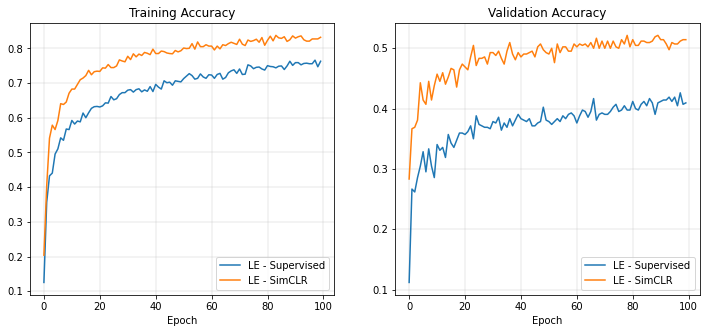

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12, 5), sharey=False)

ax[0].plot(le_sv['metrics_dict'][0]['train_acc'], label='LE - Supervised')
ax[0].plot(le_ssl['metrics_dict'][0]['train_acc'], label='LE - SimCLR')

ax[0].legend()
ax[0].grid(linewidth=0.3)
ax[0].set_title('Training Accuracy')
ax[0].set_xlabel('Epoch')

ax[1].plot(le_sv['metrics_dict'][0]['valid_acc'], label='LE - Supervised')
ax[1].plot(le_ssl['metrics_dict'][0]['valid_acc'], label='LE - SimCLR')

ax[1].legend()
ax[1].grid(linewidth=0.3)
ax[1].set_title('Validation Accuracy')
ax[1].set_xlabel('Epoch')

Text(0.5, 0, 'Epoch')

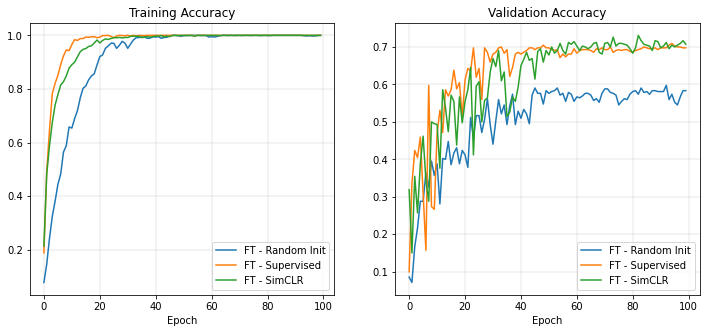

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(12, 5), sharey=False)

ax[0].plot(ft_rand['metrics_dict'][0]['train_acc'][:100], label='FT - Random Init')
ax[0].plot(ft_sv['metrics_dict'][0]['train_acc'], label='FT - Supervised')
ax[0].plot(ft_ssl['metrics_dict'][0]['train_acc'], label='FT - SimCLR')

ax[0].legend()
ax[0].grid(linewidth=0.3)
ax[0].set_title('Training Accuracy')
ax[0].set_xlabel('Epoch')

ax[1].plot(ft_rand['metrics_dict'][0]['valid_acc'][:100], label='FT - Random Init')
ax[1].plot(ft_sv['metrics_dict'][0]['valid_acc'], label='FT - Supervised')
ax[1].plot(ft_ssl['metrics_dict'][0]['valid_acc'], label='FT - SimCLR')

ax[1].legend()
ax[1].grid(linewidth=0.3)
ax[1].set_title('Validation Accuracy')
ax[1].set_xlabel('Epoch')